<font size="5">**Introduzione al VaR ed alla ES in Python**</font><br>

> (c) 2024 Antonio Piemontese

# La rilevazione dell'ambiente
**Il presente notebook funziona sia in Jupyter Notebook che Google Colab**.
A questo scopo, per garantire la compatibilità di alcune celle di codice con entrambi gli ambienti indicati, **rileviamo l'ambiente di esecuzione del notebook** (Jupyter oppure Google Colab): la seguente cella imposta una **variabile booleana `IN_COLAB`** che sarà poi **testata** da alcune celle del notebook (in particolare quelle di visualizzazione di immagini e PDF) per personalizzarne il comportamento a seconda dell'ambiente di esecuzione dell'ambiente rilevato.

In [1]:
# impostazione del TOGGLE BINARIO:
try:
    import google.colab                      # package disponibile SOLO in Google Colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Running on Colab:", IN_COLAB)


# IMPORT dei package necessari (necessari sia in JN, VSC che in Colab):
from IPython.display import Image, display   # import dei package di incorporamento e visualizzazione immagine (una tantum)
                                             # Image e display sono entrambi necessari a Jupyter Notebook
                                             # Google Colab utilizza solo Image
import os                                    # necessario a Google Colab per vedere da una cella codice
                                             # i contenuti del 'content'

Running on Colab: True


In [2]:
# comando solo per Google Colab
if IN_COLAB is True:
    print(os.listdir('/content'))      # la print è necessaria, altrimenti NON visualizza nulla.
                                       # la funzione 'os.listdir()' infatti restituisce una lista, che poi occorre
                                       # assegnare ad una variabile o passare ad una funzione!

['.config', 'sample_data']


In [3]:
if IN_COLAB:
  from google.colab import files
  uploaded = files.upload()  # si aprirà un prompt per caricare il PDF

# Indice

[Indice](#Indice)<br>
[Sommario](#Sommario)<br>
[Quantili e percentili](#Quantili-e-percentili)<br>
[Grafico del quantile empirico](#Grafico-del-quantile-empirico)<br>
[Caricamento dei dati](#Caricamento-dei-dati)
- [Caricamento dei dati da Yahoo Finance](#Caricamento-dati-da-Yahoo-Finance)
- [Caricamento dei dati da Alpha Vantage](#Caricamento-dati-da-Alpha-Vantage)
- [Caricamento dei dati da file csv](#Caricamento-dati-da-file-csv)
  
[Metodo analitico univariato (1 serie storica) e semplice (T=1)](#Metodo-analitico-univariato-e-semplice)<br>
[Metodo analitico univariato (1 serie storica) e con T > 1](#Metodo-analitico-univariato-e-multiperiodo)<br>
[Metodo analitico multivariato (diverse serie storiche) e multiperiodo (T > 1)](#Metodo-analitico-multivariato-e-multiperiodo)<br>
- [Calcolo del VaR dell'esempio 13_10 di Brandimarte](#Calcolo-del-VaR-dell'esempio-13_10-di-Brandimarte)
- [Il ruolo della correlazione](#Il-ruolo-della-correlazione)
- [Formula del prof. Karasan (ed altri)](#Formula-del-prof-Karasan-(ed-altri))
- [VaR assoluto vs VaR relativo](#VaR-assoluto-vs-VaR-relativo)<br>

[Il VaR con il dataset di Alpha Vantage](#Il-VaR-con-il-dataset-di-Alpha-Vantage)<br>
- [I due modi di calcolo dei rendimenti](#I-due-modi-di-calcolo-dei-rendimenti)
- [Nota sul metodo shift di pandas](#Nota-sul-metodo-shift-di-pandas)
- [Il calcolo logaritmico dei rendimenti](#Il-calcolo-logaritmico-dei-rendimenti)
- [La gaussianità dei rendimenti (e della loss)](#La-gaussianità-dei-rendimenti-(e-della-loss))
- [Il calcolo aritmetico dei rendimenti](#Il-calcolo-aritmetico-dei-rendimenti)
- [Il calcolo del VaR analitico multi-variato e multi-periodo (T>1)](#Il-calcolo-del-VaR-analitico-multivariato-e-multiperiodo-(T>1))
  - [La formula](#La-formula)
  - [L'inferenza](#L'inferenza)
  - [La funzione python](#La-funzione-python)
  - [Il VaR analitico multi-periodo](#Il-VaR-analitico-multiperiodo)
  - [Rendimenti auto-correlati?](#Rendimenti-autocorrelati?)
- [VaR analitico con la distribuzione t di Student](#VaR-analitico-con-la-distribuzione-t-di-Student)<br>
- [Il VaR simulato in modo storico](#Il-VaR-simulato-in-modo-storico)<br>
- [Il VaR di Montecarlo](#Il-VaR-di-Montecarlo)<br>

[Stressed VaR](#Stressed-VaR)<br>
[Expected Shortfall](#Expected-Shortfall)
- [ES analitico](#ES-analitico)
- [ES storico](#ES-storico)

[Funzioni VaR della Bocconi](#Funzioni-VaR-della-Bocconi)<br>
[Come usare le funzioni di questo notebook con i propri dati](#Come-usare-le-funzioni-di-questo-notebook-con-i-propri-dati)

# Sommario
[[torna ad indice]](#Indice)

Dopo una breve introduzione al concetto di percentile e **quantile**, indispensabile per la comprensione di **VaR** ed **Expected Shortfall**, ed il **caricamento dei dati** di prova, il notebook definisce **queste funzioni**:
* *VaR_analytic()*
* *VaR_historical()*
* *VaR_MonteCarlo()*
* *ES_analytic()*
* *ES_historical()* - **baco in corso di correzione**

Le funzioni possono essere usate come scatole nere, ma è più produttivo comprenderne il funzionamento interno.<br>

Al termine del notebook sono fornite le **indicazioni pratiche** su come usare le funzioni con i **propri dati**.

In [ ]:
# i soliti package
import pandas as pd
import numpy as np

# package statistici
import scipy.stats
from scipy.stats import norm, t

# package per plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# package per gestione date:
import datetime as dt

# per stampare i separatori:
import locale

# per caricamento dati già pronti (da fonti esterne)
import yfinance as yfin                    # fare prima 'pip install yfinance' da prompt anaconda
from pandas_datareader import data as pdr  # fare prima 'pip install pandas_datareader' da prompt anaconda

# per usare la API di Alpha Vantage:
import requests
from io import StringIO

# per visualizzare il correlogramma
from statsmodels.graphics.tsaplots import plot_acf

# per disabilitare i warning
import warnings
warnings.filterwarnings('ignore')

# per impostare le dimensioni e la risoluzione delle immagini
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Quantili e percentili
[[torna ad indice]](#Indice)

Il VaR, come detto, è un [quantile](https://it.wikipedia.org/wiki/Quantile) (della distribuzione della loss).<br>
E' un termine probabilistico; in statistica si usa l'analogo termine [percentile](https://it.wikipedia.org/wiki/Centile). I qua**r**tili al 25, 50 e 75 per cento sono percentili particolari.<br>
I percentili si misurano da 0 a 100, i quantili da 0 ad 1.<br>
Ci sono molti modi di calcolare i quantili o percentili. Spesso alcune funzioni software hanno il loro modo personalizzato.

Per sapere quando usare l'uno o l'altro in Python e con quali funzioni vedi [qui](https://www.kaggle.com/code/aungdev/np-percentile-vs-np-quantile) e [qui](https://stackoverflow.com/questions/55379220/when-to-use-np-quantile-and-np-percentile).

Vediamo la differenza pratica tra i due in Python su **dati dummy**.

In [ ]:
x = np.arange(-5, 5, 0.01)                     # dati DUMMY: le nostre osservazioni (ipotetici rendimenti)
print(list(x)[0:9])                            # una serie di dati da -5 a 5 con intervalli regolari di 0.01 (i primi 10)

[np.float64(-5.0), np.float64(-4.99), np.float64(-4.98), np.float64(-4.970000000000001), np.float64(-4.960000000000001), np.float64(-4.950000000000001), np.float64(-4.940000000000001), np.float64(-4.9300000000000015), np.float64(-4.920000000000002)]


In [ ]:
print(np.quantile(x, 0.5))                     # correttamente vicono a 0 (l'ultimo elemento di x NON è 5)
print(np.percentile(x,50))

-0.005000000000106475
-0.005000000000106475


Questi sono quantili (o percentili) **empirici**, cioè ricavati dalla [distribuzione empirica](https://it.wikipedia.org/wiki/Funzione_di_ripartizione_empirica) dei dati. Cioè, i quantili (o percentili) empirici servono quando la distribuzione non è nota, e noi abbiamo semplicemente un campione, dal quale appunto ricavare il quantile (empirico).<br>
Ci sono poi i quantili **teorici**, relativi ad una data distribuzione teorica, ad esempio la gaussiana standard (vedi [qui](https://stats.stackexchange.com/questions/3438/calculating-percentile-of-normal-distribution) - seconda risposta); ad esempio:

In [ ]:
# vediamo due quantili della gaussiana standard:
print(scipy.stats.norm.ppf(q=0.95))     # con default 0 ed 1 di 'loc' e 'scale'
print(scipy.stats.norm.ppf(q=0.99))     #  "     "               "

1.6448536269514722
2.3263478740408408


`ppf`: Probability Point Function. *The Probability Point Function or PPF is the inverse of the CDF. Specifically, the PPF returns the exact point where the probability of everything to **the left** is equal to q. This can be thought of as the percentile function since the PPF tells us the value of a given percentile of the data.*<br>

In pratica, il metodo *ppf*, per <u>una data distribuzione di probabilità</u>, restituisce il **quantile** (il valore sull'asse delle X) europeo per un determinato livello di confidenza (l'argomento `q`, un nome non felice perchè richiama il quantile!), cioè l'area a sx del quantile restituito deve essere pari alla probabilità indicata.<br>

Nel caso di una gaussiana (**non necessariamente standard!)** forniamo al metodo `ppf` della classe `scipy.stats.norm` i due parametri $\mu$ e $\sigma$ che caratterizzano la distribuzione gaussiana mediante i due argomenti `loc` e `scale`, che hanno default 0 ed 1 (gaussiana standard).<br>

La figura sottostante descrive graficamente l'input $(1-\alpha)$ e l'output *q* del metodo *ppf* per una gaussiana standard. (Si noti nuovamente come *q* è l'output della `ppf`, anche se il nome dell'argomento $1-\alpha$ si chiama purtroppo `q`!)

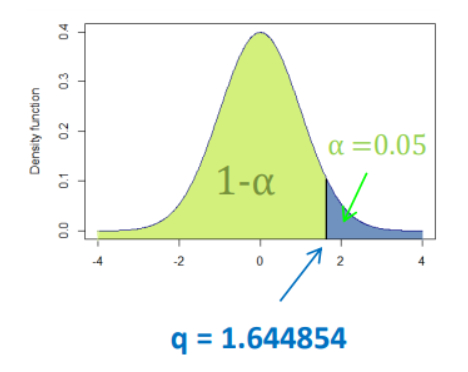

In [4]:
Image('ppf.png') if IN_COLAB else display(Image(filename='ppf.png'))

PPF è una delle funzioni di distribuzione continua: PDF, CDF e PPF appunto. Vedi in merito [questo utile post](https://machinelearningmastery.com/continuous-probability-distributions-for-machine-learning/) dell'eccellente sito  MachineLearningMastery.<br>

NB. La funzione PPF fornita in Python dal "metodo" `ppf` della classe `scipy.stats.norm`) è l'equivalente in python della funzione R `qnorm`. Per un **confronto** tra le funzioni di distribuzione *gaussiane* di Python ed R vedi [qui](https://albertotb.com/Equivalence-between-distribution-functions-in-R-and-Python/).

[Qui](https://stackoverflow.com/questions/60699836/how-to-use-norm-ppf) un utile post di *stackoverflow* sulla `ppf`.

<u>Nota Jupyter</u>: le lettere greche ed altri simboli si possono inserire nel testo di una cella markdown dentro $$ in [questo modo](https://rpruim.github.io/s341/S19/from-class/MathinRmd.html).

# Grafico del quantile empirico
[[torna ad indice]](#Indice)

Supponiamo che la x di prima sia la nostra variabile di interesse (non possono essere rendimenti perchè l'unità di misura non è corretta). E supponiamo che la loro distribuzione teorica non sia nota. E non è nota, infatti! Ancorchè le *x* siano distribuite in modo simmetrico intorno a 0 (perchè le abbiamo costruite così), la loro deviazione standard non è certamente 1.

In [ ]:
print(np.mean(x))
print(np.std(x))

-0.005000000000106411
2.8867499025720336


Vogliamo produrre un plot analogo al precedente. Supponiamo che le *x* precedenti siano distribuite in modo gaussiano con i parametri stimati prima. Calcoliamo e visualizziamo le y e sovraplottiamo il quantile empirico (all'europea) al 95%:

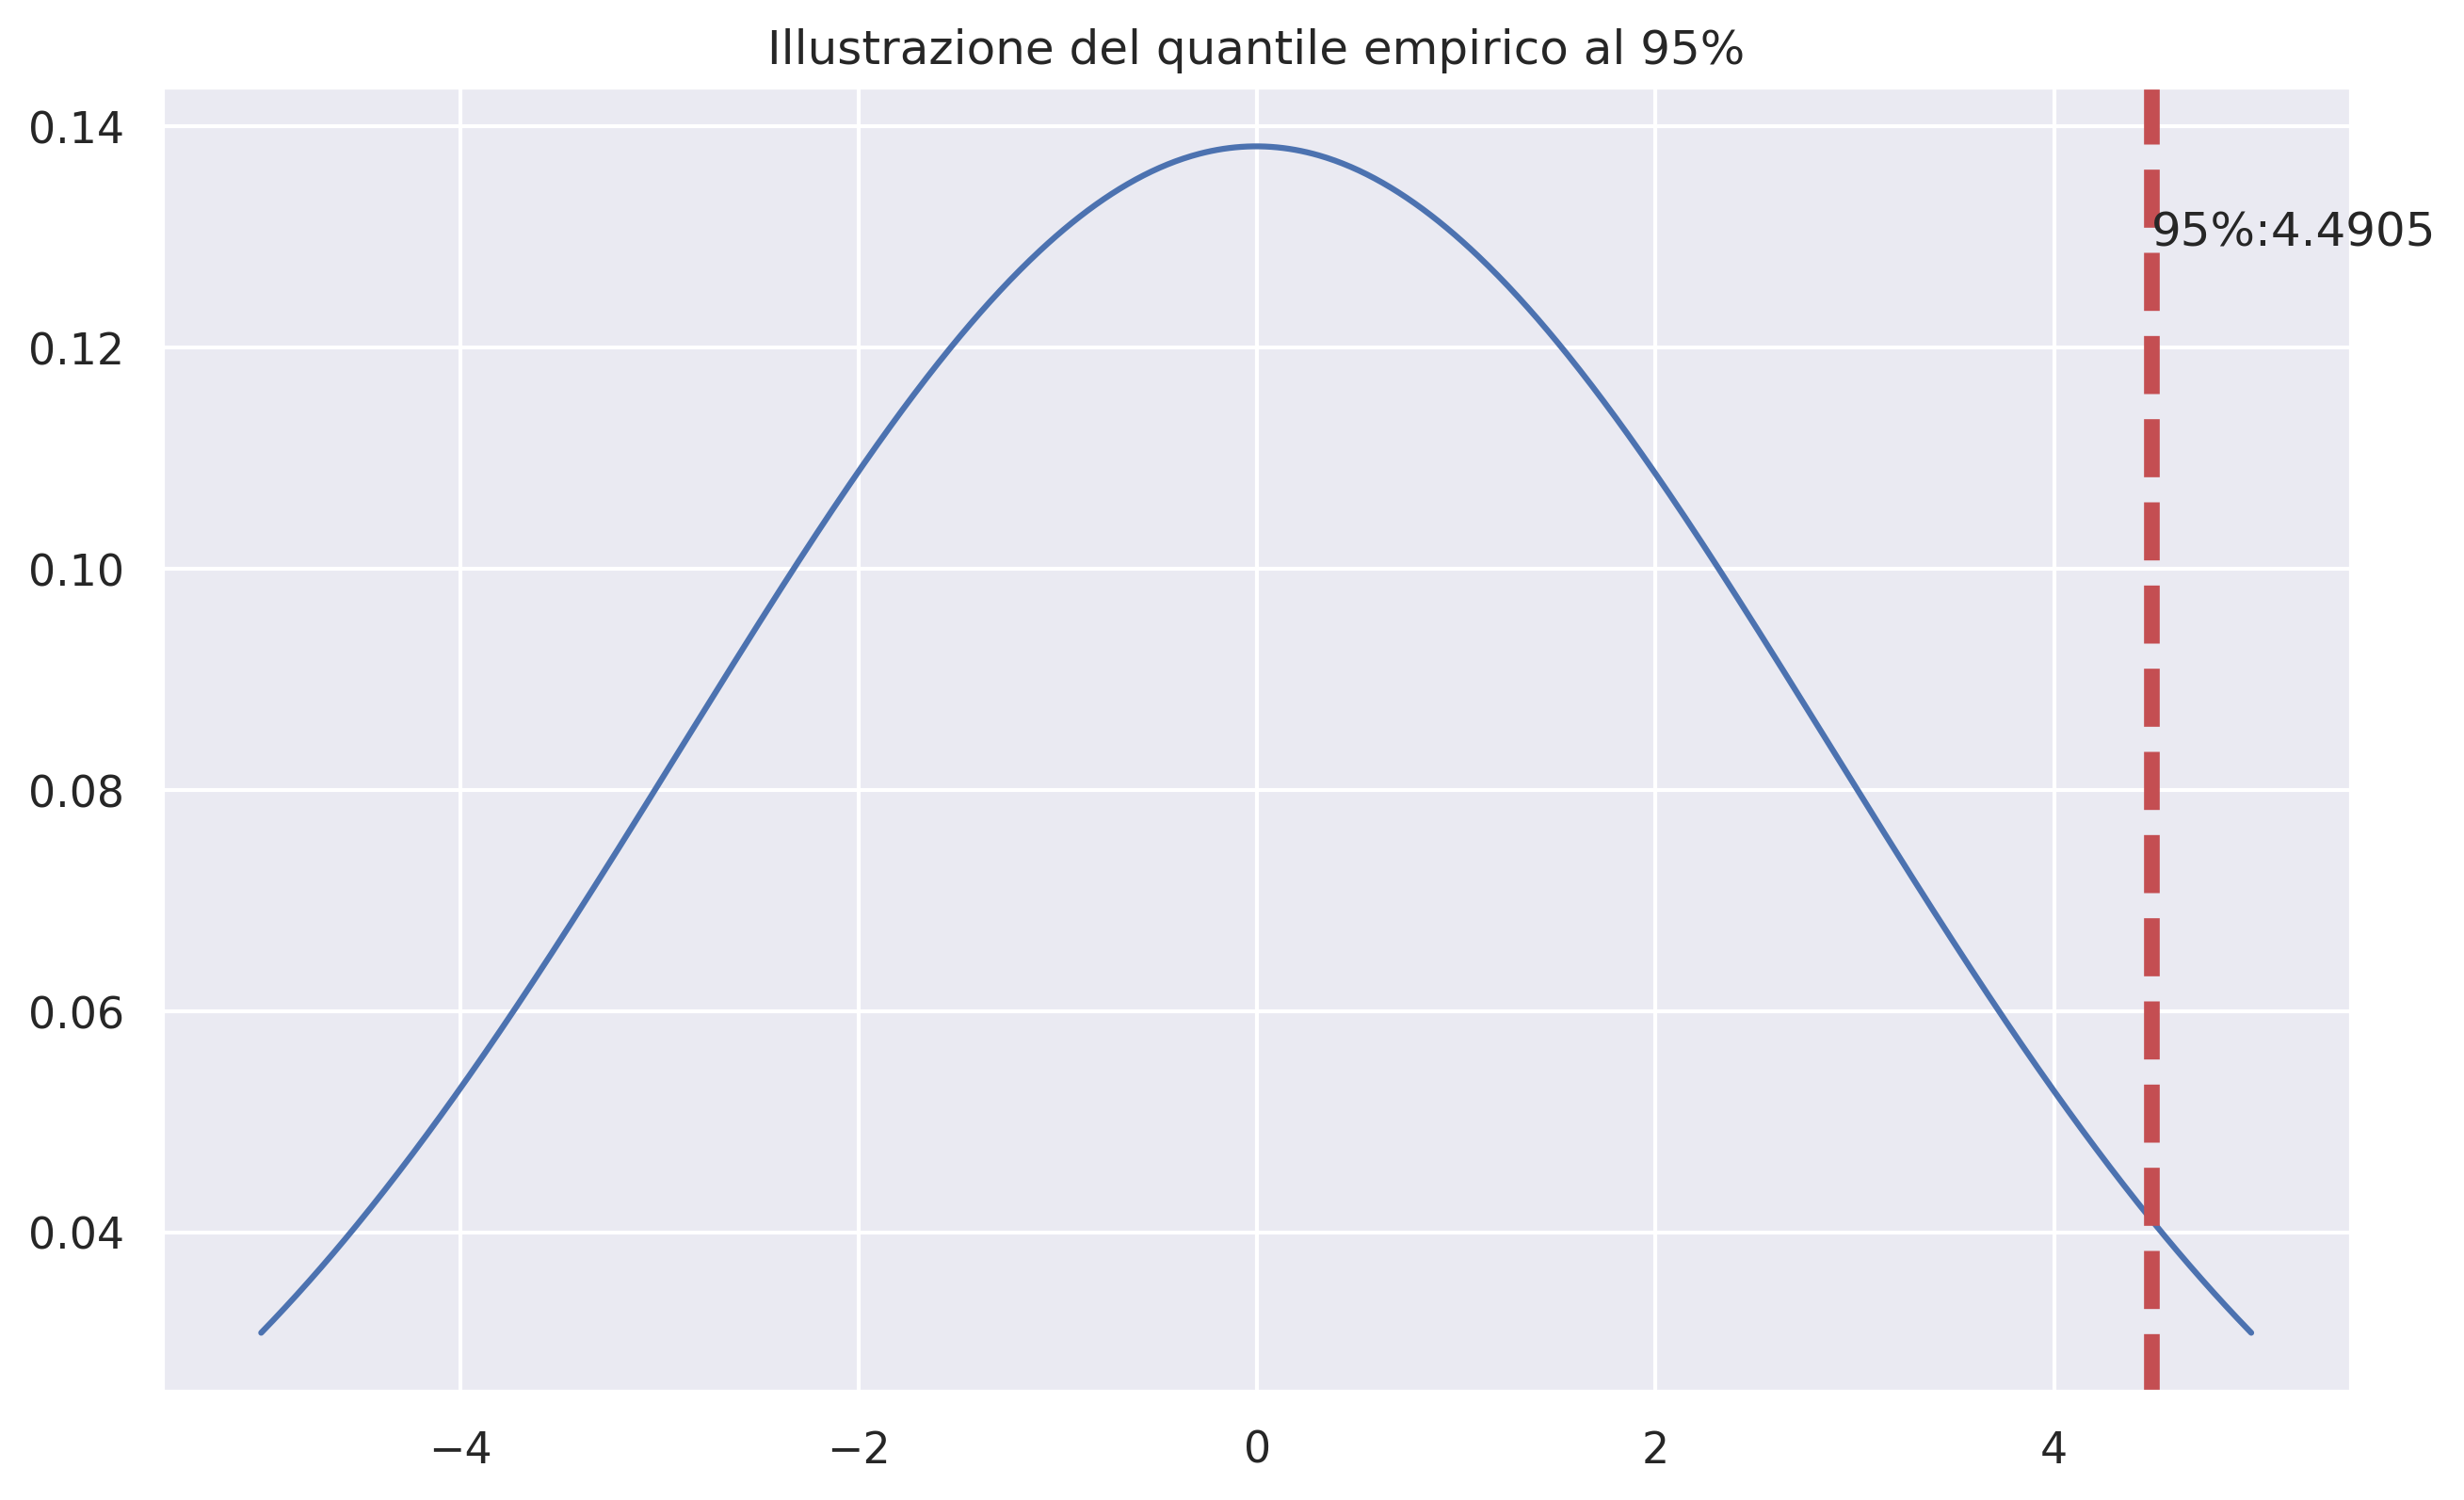

In [ ]:
mean = np.mean(x)
std_dev = np.std(x)
y = norm.pdf(x, mean, std_dev)                     # genera una PDF gaussiana con le x date prima (il 'supporto': in questo caso
                                                   # da -5 a +5) e con la media e devstd impostate all'inizio di questa cella
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()                    # i limiti all'asse Y

plt.text(np.percentile(x, 95), max_ylim * 0.9,
         '95%:{:.4f}'                              # il quantile EMPIRICO al 95% all'europea (al 5% all'americana)
         .format(np.percentile(x, 95)))            # display del quantile

plt.axvline(np.percentile(x, 95), color='r',
            linestyle='dashed',                    # display della linea verticale
            linewidth=4)

plt.title('Illustrazione del quantile empirico al 95%')
# plt.rcParams['figure.figsize'] = [4, 4]
plt.show()

In [ ]:
y[0:9]

array([0.03092864, 0.03111439, 0.03130089, 0.03148813, 0.0316761 ,
       0.03186482, 0.03205427, 0.03224447, 0.0324354 ])

Più correttamente, quello calcolato ora è il quantile di una distribuzione empirica (e non il quantile empirico).<br>
Le *x* di prima erano state costruite con passo regolare (0.01) sull'intervallo [-5,5], e quindi la distribuzione empirica è perfettamente simmetrica, e quindi la si può scambiare per una distribuzione teorica.<br>

Poichè, come noto dalla teoria: $L_T = -W_0R_T$, se il plot precedente è fatto per $x = L_T$ (anzichè per $x = $ *dummy data*), il quantile empirico $q_{1-\alpha}$ indicato sarà il $VaR_{1-\alpha}$ (storico o di Montecarlo), che è infatti un quantile della distribuzione della loss (assoluta).

> **Nel VaR analitico si usano i quantili *teorici*, nel VaR storico e di Montecarlo, si usano i quantili *empirici*.**

Fu scoperto nel 1965 che i rendimenti azionari non hanno distribuzione gaussiana a causa delle code fat e della assimetria. Quindi i rendimenti azionari hanno la [curtosi](https://it.wikipedia.org/wiki/Curtosi) più alta che la gaussiana. Curtosi alta significa code *fat*, utili a catturare i rendimenti negativi estremi.

# Caricamento dei dati
[[torna ad indice]](#Indice)

Un modo comodo, efficace e veloce per avere <u>dati azionari recenti</u> sono le **API finanziarie** (*Finance API*), ed in particolare le cosiddette **stock API**.<br>
Ce ne sono molte, per una **rassegna comparativa** vedi [qui](https://medium.com/coinmonks/best-stock-market-apis-ae1efb739ac4), [qui](https://www.abstractapi.com/guides/yahoo-finance-api-alternative) e [qui](https://patrickalphac.medium.com/stock-api-landscape-5c6e054ee631).<br>
Alcune sono a pagamento, altre gratuite.<br>

Le stock API forniscono **vari prezzi** (open, close, high e low, oltre al volume trattato ed altre info ancora) a differente livello di aggregazione (intra-day, daily, weekly, monthly, ecc). Si ritiene che i prezzi (di chiusura) più utili per le analisi delle serie storiche siano quelli cosiddetti *adjusted*:<br>
> *While the closing price simply refers to the cost of shares at the end of the day, the adjusted closing price takes dividends, stock splits, and new stock offerings into account. The adjusted closing price is a more accurate indicator of stock value since it starts where the closing price finishes.*

Vedi in merito anche l'utile voce di [Investopedia](https://www.investopedia.com/terms/a/adjusted_closing_price.asp).

Nel seguito useremo due delle migliori stock API: **Yahoo Finance** ed **Alpha Vantage**.<br>

## Caricamento dati da *Yahoo Finance*
[[torna ad indice]](#Indice)

Caricamento serie storiche azionarie da [Yahoo Finance](https://it.finance.yahoo.com/),

In [ ]:
import yfinance as yf
import pandas as pd
import datetime as dt

# 10-15 secondi sul mio PC
symbols = ["IBM"]                           # ticker (gli identificatori dei titoli azionari trattati al NYSE)
# yfin.pdr_override()                       # importante - vedi post so 74832296 (la quinta risposta, update 2 del 27.12.2022)
                                            # febbraio 2026: AttributeError: module 'yfinance' has no attribute 'pdr_override'
stock1 = yf.download(symbols,               # funzione di caricamento
                     start="2018-01-01",
                     end=dt.date.today())

stocks = pd.DataFrame(stock1)
stocks.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM
Date,,,,,
2018-01-02,103.412819,103.788254,102.936821,103.580430,4395815
2018-01-03,106.255409,107.140366,104.807289,105.484422,9875914
2018-01-04,108.407471,108.823129,106.845380,107.033098,7903785
2018-01-05,108.937096,109.211979,108.005207,108.903582,5434807
2018-01-08,109.594131,109.889121,108.407487,109.051096,5478425


In [ ]:
symbols = ["IBM", "MSFT", "INTC"]   # ticker NYSE/NASDAQ

stock3 = yf.download(               # funzione di caricamento (quasi 6 anni)
    symbols,
    start="2018-01-01",
    end=dt.date.today()
)['Close']                          # estraggo solo i prezzi di chiusura


stocks = pd.DataFrame(stock3)

stocks.tail()


[*********************100%***********************]  3 of 3 completed


Ticker,IBM,INTC,MSFT
Date,,,
2026-02-04,287.411316,48.599998,414.190002
2026-02-05,288.246582,48.240002,393.670013
2026-02-06,297.235291,50.590000,401.140015
2026-02-09,294.660004,50.240002,413.600006
2026-02-10,291.760010,47.130001,413.269989


## Caricamento dati da *Alpha Vantage*
[[torna ad indice]](#Indice)

[**Alpha Vantage**](https://www.alphavantage.co/) è una azienda che **fornisce dati** in partnership con importanti borse ed istituzioni. Tramite la API di Alpha Vintage è possibile accedere alle:
* serie storiche dei prezzi azionari con differenti intervalli temporali (orari, giornalieri, settimanali, ecc)
* serie storiche dei tassi di cambio.
* ecc<br>

Alcune serie storiche fornite da Alpha Vantage sono <u>gratuite</u>; quelle *adjusted* sono invece <u>a pagamento</u>. Vedi [qui](https://www.alphavantage.co/documentation) per l'elenco delle serie storiche disponibili e documentate.<br>

In ogni caso, per accedere a qualsiasi serie storica di Alpha Vantage  , occorre avere una **API key** da inserire nel codice, fornita da Alpha Vantage.<br>

Una chiave gratuita della API di Alpha Vantage può essere ottenuta [qui](https://www.alphavantage.co/support/#support). Con essa si può accedere a molti *endpoint* (serie storiche), tra i quali ad esempio `TIME_SERIES_INTRADAY` oppure `TIME_SERIES_DAILY`.<br>

Per ottenere il prezzo di chiusura *adjusted* (giornaliero) occorre usare l'endpoint `TIME_SERIES_DAILY_ADJUSTED`:
> *This API returns raw (as-traded) daily open/high/low/close/volume values, adjusted close values, and historical split/dividend events of the global equity specified, covering 20+ years of historical data. The OHLCV data is sometimes called "candles" in finance literature.*

Come detto, le serie storiche *adjusted* fornite da Alpha Vantage sono a pagamento; per accedere alla serie storica `TIME_SERIES_DAILY_ADJUSTED` occorre dunque procurarsi una **chiave a pagamento** (circa 25$ al mese minimo), con la quale si può accedere a <u>tutte</u> le serie storiche di Alpha Vantage (a pagamento e gratuite). L'indirizzo per farlo è [questo](https://www.alphavantage.co/premium/) [premere sul bottone `GET PREMIUM API KEY`], esistono vari piani mensili.<br>

La cella successiva utilizza la chiave a pagamento `T6X6OIMHO37KSK27`, acquistata il 25 gennaio 2024 e dunque <u>valida sino al 25 febbraio 2024</u>, che, come <u>bonus del corso</u>, è possibile **utilizzare liberamente sino al 25.2.24 per le proprie prove**. Tale chiave consente sino a **30 chiamate al minuto** alla API di Alpha Vantage e fornisce i dati del **NYSE** in tempo reale, con 15 minuti di ritardo.<br>

Estraiamo dall'endopoint `TIME_SERIES_DAILY_ADJUSTED` di Alpha Vantage i dati di **IBM**, come esempio:

In [ ]:
parameters = {'function': 'TIME_SERIES_DAILY_ADJUSTED',   # questo endpoint è a pagamento;
                                                          # l'endpoint TIME_SERIES_INTRADAY è invece gratuito, come molti altri

                       'symbol': 'IBM',                   # il titolo richiesto (IBM come esempio)
                       'outputsize':'full',               # da novembre 1991
                       'datatype': 'csv',                 # il formato richiesto (comma separated value)
                       'apikey': 'T6X6OIMHO37KSK27'}      # <--- inserire QUI la API key dell'endpoint
                                                          # precedente di dicembre 2023: ARJS8Y6X9T4VN47E
                                                          # nuova 25.1.24: T6X6OIMHO37KSK27
                                                          # (la mia DHZWYMWLZIR3JKW0 gratuita)

url = 'https://www.alphavantage.co/query'                 # la URL alla quale chiedere i dati (un sito di Alpha Vantage)

r = requests.get(url,params=parameters)                   # la richiesta al sito (dati la url ed i parametri)
                                                          # --> 'r' è la risposta

csvText = StringIO(r.text)                                # questo comando apre la risposta testuale e la converte in un
                                                          # FILE STANDARD:

                                                          # --> 'r.text' è una 'str' python (una stringa alfanumerica);
                                                          # 'StringIO' è una funzione in-memory che crea un file standard;
                                                          # sono disponibili altri formati della risposta, ad esempio: r.json()

data = pd.read_csv(csvText, index_col='timestamp')        # creazione di un dataframe pandas con indice sulla colonna timestamp;
                                                          # si usa la funzione 'read_csv' perchè il formato richiesto nei
                                                          # parametri era CSV.

data                                                      # i dati di IBM nel periodo e formato richiesti

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2026-02-10,294.99,297.61,290.330,291.76,291.760000,3837343,1.68,1.0
2026-02-09,295.91,297.72,291.420,296.34,294.643397,4627815,0.00,1.0
2026-02-06,292.50,299.89,290.657,298.93,297.218569,3744313,0.00,1.0
2026-02-05,286.10,291.81,285.100,289.89,288.230324,5532797,0.00,1.0
2026-02-04,291.41,291.41,278.960,289.05,287.395134,8708033,0.00,1.0
...,...,...,...,...,...,...,...,...
1999-11-05,92.75,92.94,90.190,90.25,44.295173,13737600,0.00,1.0
1999-11-04,94.44,94.44,90.000,91.56,44.938128,16697600,0.00,1.0
1999-11-03,95.87,95.94,93.500,94.37,46.317291,10369100,0.00,1.0


La precedente cella ha usato la funzione [StringIO()](https://www.geeksforgeeks.org/stringio-module-in-python/).<br>
*The StringIO module is an **in-memory file-like object**. This object can be used as input or output to the most function that would **expect a standard file object**. When the StringIO object is created it is initialized by passing a string to the constructor. If no string is passed the StringIO will start empty. In both cases, the initial cursor on the file starts at zero.*

*NOTE: This module does not exist in the latest version of Python so to work with this module we have to import it from the io module in Python as **io.StringIO**.*

Creiamo ora una **funzione** (`getDailyData()`) che esegue il codice precedente per **tutti** i titoli azionari richiesti (e non solo per IBM!).

In [ ]:
def getDailyData(symbol):                                          # 'symbol' è la lista dei titoli richiesti
        parameters = {'function': 'TIME_SERIES_DAILY_ADJUSTED',
                       'symbol': symbol,                           # <-- i titoli richiesti (anche più di uno)
                       'outputsize':'full',
                       'datatype': 'csv',
                       'apikey': 'T6X6OIMHO37KSK27'}

        url = 'https://www.alphavantage.co/query'

        r = requests.get(url,params=parameters)

        csvText = StringIO(r.text)

        data = pd.read_csv(csvText, index_col='timestamp')

        return data                                                # 'data' è l'output della funzione

**Testiamo** la funzione appena creata con il titolo IBM.<br>
La cella successiva funziona solo se la funzione `getDailyData()` è stata definita con una **API key** valida!

In [ ]:
symbol = ["IBM"]
getDailyData(symbol)

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2026-02-10,294.99,297.61,290.330,291.76,291.760000,3837343,1.68,1.0
2026-02-09,295.91,297.72,291.420,296.34,294.643397,4627815,0.00,1.0
2026-02-06,292.50,299.89,290.657,298.93,297.218569,3744313,0.00,1.0
2026-02-05,286.10,291.81,285.100,289.89,288.230324,5532797,0.00,1.0
2026-02-04,291.41,291.41,278.960,289.05,287.395134,8708033,0.00,1.0
...,...,...,...,...,...,...,...,...
1999-11-05,92.75,92.94,90.190,90.25,44.295173,13737600,0.00,1.0
1999-11-04,94.44,94.44,90.000,91.56,44.938128,16697600,0.00,1.0
1999-11-03,95.87,95.94,93.500,94.37,46.317291,10369100,0.00,1.0


In [ ]:
# estrazione del solo prezzo di chiusura (aggiustato):
getDailyData(symbol)['adjusted_close']

,adjusted_close
timestamp,
2026-02-10,291.760000
2026-02-09,294.643397
2026-02-06,297.218569
2026-02-05,288.230324
2026-02-04,287.395134
...,...
1999-11-05,44.295173
1999-11-04,44.938128
1999-11-03,46.317291


In [ ]:
# la stessa serie temporale di prima, ma in ordine temporale ASCENDENTE:
getDailyData(symbol)[::-1]['adjusted_close']

,adjusted_close
timestamp,
1999-11-01,47.485407
1999-11-02,46.533245
1999-11-03,46.317291
1999-11-04,44.938128
1999-11-05,44.295173
...,...
2026-02-04,287.395134
2026-02-05,288.230324
2026-02-06,297.218569


Finito il test, ora **costruiamo il nostro dataset**, relativo ai **3 titoli** ed al **solo 2020**:

In [ ]:
symbols = ["IBM", "MSFT", "INTC"]                       # i 3 titoli richiesti

stock3 = []                                             # la inizializzazione del vettore di output

for symbol in symbols:                                  # il ciclo iterativo
    stock3.append(getDailyData(symbol)[::-1]['adjusted_close']
                  ['2020-01-01': '2020-12-31'])         # caricamento dei dati del periodo indicato ed append dei prezzi
                                                        # azionari dei 3 titoli

# creazione del dataframe di stock3 trasposto (come righe e colonne, più comodo!)
stocks = pd.DataFrame(stock3).T                         # l'operatore T traspone righe e colonne (ed unisce le tre serie!)
stocks.columns = symbols                                # i nomi delle colonne del dataframe
stocks.head()

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,99.321772,152.494581,53.666888
2020-01-03,98.529662,150.595757,53.014135
2020-01-06,98.353638,150.985016,52.864178
2020-01-07,98.419647,149.608368,51.982079
2020-01-08,99.241094,151.991393,52.017363


## Caricamento dati da file csv
[[torna ad indice]](#Indice)

Per coloro che non dispongono di una connessione internet, la seguente cella carica il dataframe `stocks` **del 2020** da file csv, fornito separatamente.

In [ ]:
stocks = pd.read_csv("alpha_vantage_2020.csv")
stocks.set_index(keys = 'timestamp', inplace = True)
stocks.head()

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,106.204283,154.761572,54.396808
2020-01-03,105.357284,152.834520,53.735177
2020-01-06,105.169062,153.229566,53.583180
2020-01-07,105.239645,151.832453,52.689084
2020-01-08,106.118015,154.250903,52.724848


# Metodo analitico univariato e semplice
[[torna ad indice]](#Indice)

Cioè, 1 serie storica e T=1.

Come sempre con il VaR, si può lavorare con un singolo asset o con un portafoglio. Si abbia un singolo asset.<br>
Si assuma che il rendimento del titolo sia **gaussiano**. Sotto questa assunzione l'applicazione del metodo diventa facile.<br>

Esempio della **Quacko Corporation** (visto nella teoria di Brandimarte), che si riporta qui sotto per comodità:<br>


Dalla formula ${\sf VaR_{1-\alpha} = z_{1-\alpha}{\sigma}W_0}$ si ricava:<br>

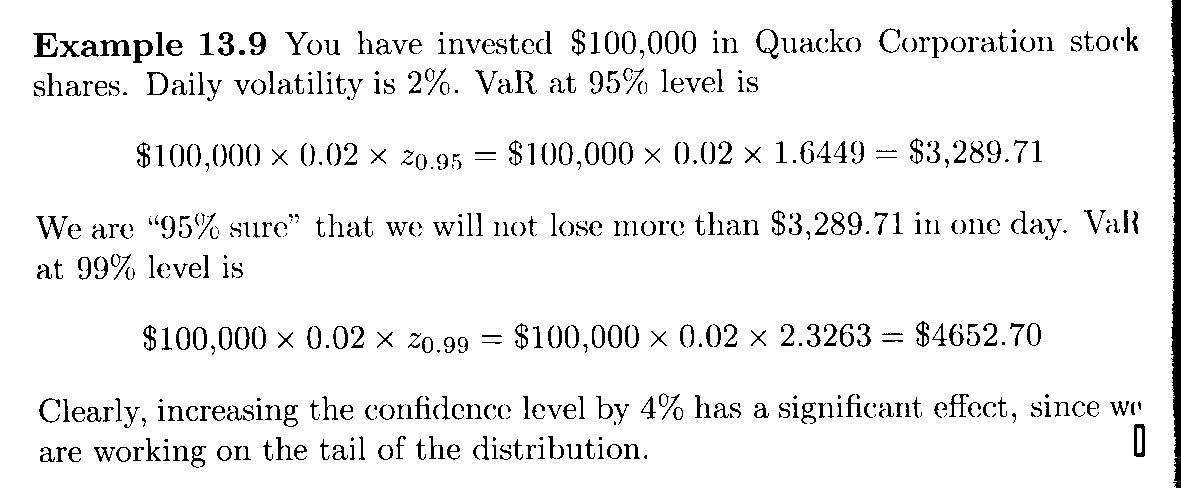

In [7]:
Image('esempio_13_9.png',width=600) if IN_COLAB else display(Image(filename='esempio_13_9.png'))

In [ ]:
W0 = 100000                                  # capitale iniziale
sigma = 0.02                                 # variabilità giornaliera dell'asset
q = scipy.stats.norm.ppf(q=0.95)             # il quantile al 95% di una gaussiana standard (Z_1-alpha)

# round(W0*sigma*q*np.sqrt(T),2)             # VaR al 95% --.> restituisce ANCHE il formato (np.float64)
round(float(W0*sigma*q*np.sqrt(T)),2)        # VaR al 95% --.> restituisce SOLO il valore


7356.01

<u>Limite di questo metodo</u>: poichè le code gaussiane non sono *fat*, esso non può quindi stimare rendimenti negativi estremi, che possono avvenire soprattutto in periodi di crisi.<br>
La seguente distribuzione gaussiana (non necessariamente standard, perchè $\mu$ e $\sigma$ non sono indicati) mostra come all'esterno dell'intervallo [$-3\sigma,+3\sigma$] resti fuori un'area ben piccola. La distribuzione gaussiana NON modella bene i rischi. La si continua ad usare nella gestione del rischio finanziario perchè ha delle proprietà analitiche molto comode (vedi più avanti).

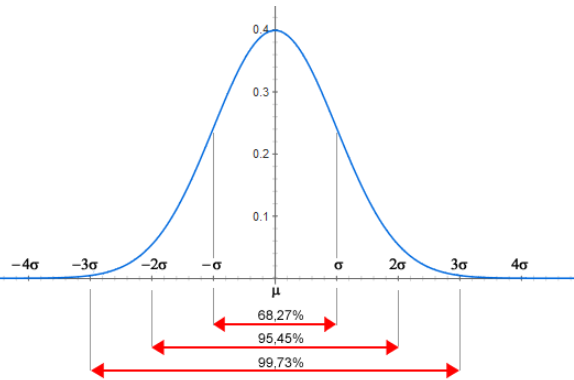

In [8]:
Image('sigma_gaussiani.png',width=600) if IN_COLAB else display(Image(filename='sigma_gaussiani.png'))

Se $\sigma$ non è nota, la si stima dai dati (1 anno di rendimenti è ritenuto sufficiente).

# Metodo analitico univariato e multiperiodo
[[torna ad indice]](#Indice)

Cioè, 1 serie storica e T>1.

Si voglia calcolare il VaR analitico univariato per un periodo di detenzione (*holding period*) > 1. Ad esempio, poichè in questo caso $\sigma$ è giornaliera, calcoliamo il VaR analitico a T giorni:

In [ ]:
T = 5                                    # il periodo di detenzione
W0 = 100000                              # capitale iniziale
sigma = 0.02                             # variabilità giornaliera dell'asset
q = scipy.stats.norm.ppf(q=0.95)         # il quantile al 95% di una gaussiana standard (Z_1-alpha)
round(float(W0*sigma*q*np.sqrt(T)),2)    # VaR al 95%

7356.01

Come si vede, ovviamente il VaR multi-periodo (T>1) è cresciuto rispetto al VaR singolo periodo (T=1), ma in modo non-lineare rispetto a T. Ad esempio, con T=10 otteniamo un VaR intorno a 10.000 e non a 15.000 (se la crescita fosse lineare).

# Metodo analitico multivariato e multiperiodo
[[torna ad indice]](#Indice)

Cioè diverse serie storiche e T>1.

Aka, metodo della **varianza-covarianza**.

Applichiamo il metodo analitico al **caso più frequente e più utile**, e cioè con un <u>portafoglio</u> di asset (e non un solo asset) e con un <u>orizzonte temporale *t* > 1</u>.<br>
Vedremo questo caso applicato a due <u>esempi differenti</u>:
* l'esempio 13.10 di Brandimarte, nel quale la struttura di correlazione è **fornita**, cioè la struttura della <u>popolazione</u> è in qualche modo nota o assunta
* le tre serie storiche prima estratte da Yahoo Finance, nel quale la struttura di correlazione non è nota e deve dunque essere **inferita** dal <u>campione</u>

Entrambi i casi comunque assumono la gaussianità della [distribuzione congiunta](https://it.wikipedia.org/wiki/Distribuzione_congiunta). Il link precedente di Wikipedia ne fornisce i dettagli matematici (non banali). A livello intuitivo, possiamo dire che una distribuzione congiunta fornisce i valori di probabilità per TUTTE le possibili combinazioni dei valori delle variabili indipendenti.

## Calcolo del VaR dell'esempio 13_10 di Brandimarte
[[torna ad indice]](#Indice)

Lo si riporta qui sotto (dall'altro notebook) per comodità:

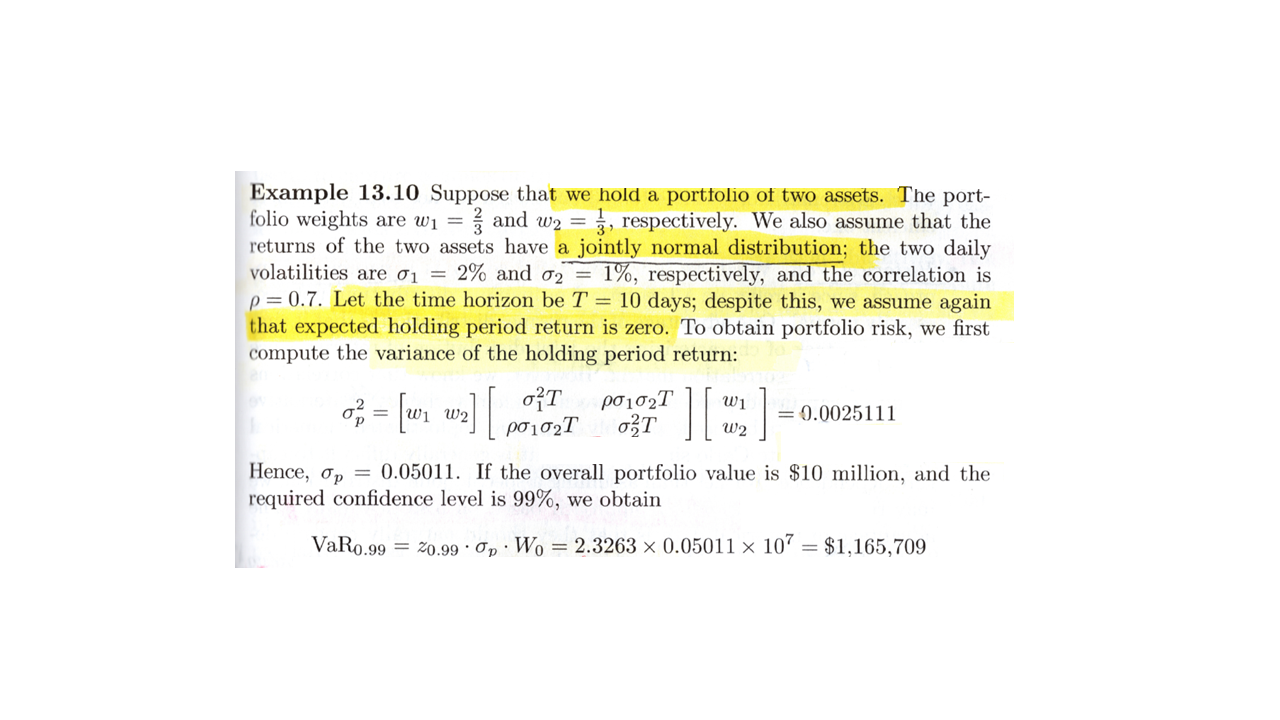

In [9]:
Image('esempio_13_10.png',width=1000) if IN_COLAB else display(Image(filename='esempio_13_10.png'))


Calcoliamo questo VaR.<br>
Pesi ed orizzonte temporale sono forniti dall'esempio.<br>
Devstd giornaliere dei singoli rendimenti e correlazione sono forniti dall'esempio (della **popolazione**?).<br>
Per prima cosa si deve calcolare la varianza del rendimento del portafoglio:

In [ ]:
# input forniti dall'esempio 13_10:
weights_13_10 = [0.6666, 0.3333]         # il vettore COLONNA dei pesi (una lista Python)
weights_13_10 = np.array(weights_13_10)  # la lista trasformata in una array 1D di Python (altrimenti non la si può trasporre dopo)
T = 10                                   # l'orizzonte temporale (in giorni)
sigma_1 = 0.02                           # la dev std (giornaliera) del rendimento del primo asset (della POPOLAZIONE)
sigma_2 = 0.01                           # la dev std (giornaliera) del rendimento del secondo asset (della POPOLAZIONE)
rho = 0.7                                # la correlazione tra i due asset (della POPOLAZIONE)

# la matrice di var-cov è dunque CALCOLABILE in questo caso (quella della popolazione):
var_cov_13_10 = np.array([[np.power(sigma_1,2)*T, rho*sigma_1*sigma_2*T], [rho*sigma_1*sigma_2*T,np.power(sigma_2,2)*T]])
var_cov_13_10                            # la matrice SIGMA delle var-cov, moltiplicata per T elemento per elemento

array([[0.004 , 0.0014],
       [0.0014, 0.001 ]])

La varianza del portafoglio è dunque:

In [ ]:
var_port = weights_13_10.T.dot(var_cov_13_10).dot(weights_13_10)    # l'operatore 'dot' fa il prodotto interno tra
                                                                    # vettori e matrici
round(float(var_port),5)

0.00251

In [ ]:
round(float(np.sqrt(var_port)),5)   # la stessa precisione decimale di Brandimarte

0.05011

Breve **nota matematica** sulla dinamica delle moltiplicazioni nell'algebra lineare:

Vediamo, solo per capire meglio, i risultati intermedi del calcolo precedente:

In [ ]:
res_int = weights_13_10.T.dot(var_cov_13_10)   # un vettore trasposto x una matrice dà un vettore riga (trasposto)
                                               # al contrario, una matrice per un vettore dà un vettore colonna

In [ ]:
float(res_int.dot(weights_13_10))              # un vettore trasporto (riga) x un vettore colonna dà un numero (moltiplicazione component-wise)
                                               # --> stesso risultato di prima

0.0025106089139999995

In [ ]:
print(res_int)
print(weights_13_10)

[0.00313302 0.00126654]
[0.6666 0.3333]


In [ ]:
(0.00313302*0.6666)+(0.00126654*0.3333)

0.0025106089139999995

**Fine nota matematica**

A questo punto, usando la formula di Brandimarte, il calcolo del VaR al 99% è banale:

In [ ]:
W0 = 1e7                                         # 10 milioni
q = scipy.stats.norm.ppf(q=0.99)                 # il quantile al 99% di una gaussiana standard (loc=0, scale=1)
VaR_13_10_brandimarte = q*np.sqrt(var_port)*W0   # il VaR cercato
round(VaR_13_10_brandimarte)

1165639

Il risultato ottenuto in python differisce leggermente da quello fornito dall'esempio 13_10 (cartaceo) a causa dei <u>differenti modi di calcolare i quantili dei vari software</u>.

In [ ]:
# per stampare i separatori:
import locale

# tentativo di impostare un 'locale' German più specifico (potrebbe NON essere disponibile)
# se 'de_DE.UTF-8' also fallisce, considerare dei metodi di formattazione alternativi
try:
    locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
except locale.Error:
    print("Warning: 'de_DE.UTF-8' locale not supported. Falling back to default or alternative formatting.")
    # Fallback to an English locale or skip setting if not critical, or use f-string/pandas formatting
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') # Common fallback

# 'German_Germany.1252' is just a string, not an action
# print(locale.format('%.2f', VaR_13_10_brandimarte, True))

# Using f-string for formatting which is more platform-independent
print(f"{VaR_13_10_brandimarte:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")) # Custom format for German style

1.165.639,33


> Il metodo ora visto è facilmente **estendibile** nei suoi parametri - *n* asset anzichè 2, qualsiase valore di *T* (a patto che regga l'assunzione $\mu_p \approx 0$), ecc -- con piccoli <u>aggiustamenti di programmazione</u>, ad esempio creando una matrice var-cov $\Sigma$ con *n* righe ed *n* colonne anzichè 2 righe e 2 colonne come fatto prima, purchè la matrice $\Sigma$ sia nota (ed ovviamente regga l'ipotesi di gaussianità).

> **CONSIGLIO**: Nel caso la matrice di varianza-covarianza $\Sigma$ **non** sia nota (e non assumibile gaussiana, per vari motivi), la si può **inferire** dalla popolazione (come mostrato sotto con il metodo `cov`) e poi si possono applicare le **formule di Brandimarte** viste prima (con il quantile teorico ovviamente sostituito da quello empirico, cioè il quantile della distribuzione empirica).

## Il ruolo della correlazione
[[torna ad indice]](#Indice)

E' interessante confrontare il rischio del portafoglio con i rischi delle due singole posizioni. Si consideri questo esempio:
* un portafoglio di 2 titoli A e B, sui quali abbiamo investito: $W_A = 10.000$ e $W_B = 20.000$
* assumiamo che i due rendimenti siano congiuntamente gaussiani con $\sigma_A = 2$%, $\sigma_B = 3$% e $\rho_{AB} = 0.4$

e si volglia calcolare $VaR_{0.99, 1day}$.<br>
Applichiamo la seguente formula per il calcolo preliminare della devstd del rendimento del portafoglio, che è un ri-aggiustamento di quella analoga vista precedentemente:

$$\sigma_p = \sqrt{W_A^2\sigma^2_A + W_B^2\sigma^2_B + 2W_AW_B\rho\sigma_A\sigma_B}$$

In [ ]:
# input forniti dall'esempio 2_3 di Brandimarte3:
W_A = 10000
W_B = 20000
sigma_A = 0.02
sigma_B = 0.03
rho_AB = 0.4
conf_level = 0.99

# il calcolo della deviazione standard del portafoglio:
sigma_p = np.sqrt(np.power(W_A,2)*np.power(sigma_A,2) + np.power(W_B,2)*np.power(sigma_B,2) + 2*W_A*W_B*rho_AB*sigma_A*sigma_B)

# il calcolo del VaR analitico di portafoglio:
q = scipy.stats.norm.ppf(q=0.99)
VaR_p_99 = q*sigma_p
round(float(VaR_p_99),2)

1638.38

Calcoliamo ora i due VaR delle singole posizioni:

In [ ]:
VaR_A_99 = q*W_A*sigma_A
round(float(VaR_A_99),2)

465.27

In [ ]:
VaR_B_99 = q*W_B*sigma_B
round(float(VaR_B_99),2)

1395.81

> Si ha quindi: VaR_p_99 (1638.38) <= VaR_A_99 (465.27) + VaR_B_99 (1395.81) = 1861.08.<br>
Cioè, **il rischio del portafoglio è inferiore alla somma dei due rischi**. La quantità di questa riduzione dipende dalla correlazione. Le due quantità sono le stesse con correlazione perfettamente positiva ($\rho=1$), mentre il rischio di portafoglio è minimizzato da correlazione perfettamente negativa ($\rho = -1$).

## Formula del prof Karasan (ed altri)
[[torna ad indice]](#Indice)

Il [prof. Karasan](https://www.linkedin.com/posts/abdullahkarasan_ml-for-risk-management-activity-6925215926116085760-XneO/?originalSubdomain=it), per il calcolo del VaR analitico multi-variato, usa la seguente formula:<br>

${\sf VaR_{1-\alpha} = W_0 - W_0 * (1+r_\alpha)}$

dove $r_{\alpha}$ è il quantile $\alpha$ (all'europea) di una gaussiana congiunta dei rendimenti con $\hat{\mu}$ e $\hat{\Sigma}$ stimati dalla popolazione (con almeno 1 anno di storia). **E' denominato $r$ perchè è un rendimento!**<br>
$W_0$ è l'investimento su tutto il portafoglio.<br>
Applichiamo questa formula all'esempio 13_10 precedente.

In [ ]:
# il calcolo del VaR dell'esempio 13_10 precedente con la formula di Karasan:
conf_level = 0.99                                                          # qui esplicitato (Brandimarte lo mette
                                                                           # direttamente nella funzione 'ppf');

initial_investment = W0                                                    # termine differente da Brandimarte;

# le due variabili 'conf_level' e 'initial_investment', qui sopra impostate, ci accompogneranno per il resto del notebook.
# in tutti gli esempi

std_port = np.sqrt(weights_13_10.T.dot(var_cov_13_10).dot(weights_13_10))  # è la 'var_port' di Brandimarte, ma con la
                                                                           # radice quadrata perchè qui si usa la dev-std;
                                                                           # (la formula utilizza qui in input la stessa
                                                                           # matrice var-cov di Brandimarte, ovviamente)

alpha = scipy.stats.norm.ppf(q = 1 - conf_level, loc=0, scale = std_port)  # è il quantile al livello di tolleranza alpha,
                                                                           # anzichè al livello di confidenza
                                                                           # (1-alpha) come Brandimarte, e con 'std_port'
                                                                           # <> 1 (cioè di una gaussiana non-standard!)
VaR_13_10_karasan = (initial_investment - initial_investment * (1 + alpha))
print("VaR Karasan: ",np.round(VaR_13_10_karasan))

VaR Karasan:  1165639.0


Abbiamo ottenuto lo stesso identico risultato di Brandimarte! Le due formule infatti sono **matematicamente equivalenti** (vedi Brandimarte pp. 712-713). Infatti:<br><br>
$\sf {VaR_{1-\alpha} = W_0 - (W_0 + r_{\alpha})}$ (*la formula di Karasan*) = ... proseguendo lo sviluppo algebrico: $\sf { W_0 - W_0 - W_0r_{\alpha} = -W_0r_{\alpha}}$<br><br>
dove $r_{\alpha}$, come detto prima, è l'`alpha` del codice della cella precedente, e cioè il quantile $\alpha$ della distribuzione congiunta (gaussiana, non standard!) dei rendimenti del portafoglio, ovvero $N(\hat{\mu},\hat{\Sigma})$, con $\hat{\mu}$ e $\hat{\Sigma}$ stimati dai dati storici dei rendimenti degli asset. Per l'assunzione alla base del VaR analitico (una delle tre - vedi il notebook di teoria) che $E[R_t] \approx 0$, nella linea di codice che calcola `alpha` si è posto $\hat{\mu}$ (chiamato `loc`) $= 0$.<br><br>
Si dimostra che: $\sf {r_{\alpha} = - \frac{VaR_{1-\alpha}}{W_0}}$. Infatti, per definizione di VaR si ha: $\sf {P[L_T \ge  VaR_{1-\alpha}] = \alpha}$, cioè riscrivendo:<br><br>
$\sf {P[L_T \ge  VaR_{1-\alpha}] = P[-W_0R_T \ge VaR_{1-\alpha}] = P[R_T \le -\frac{VaR_{1-\alpha}}{W_0}] = P[R_T \le r_\alpha] = \alpha}$  <br><br>
Dunque, continuando lo sviluppo precedente, si ha che :<br><br>
$\sf {-W_0r_{\alpha} = - W_0 (-\frac{VaR_{1-\alpha}}{W_0}) = VaR_{1-\alpha}}$  *(cvd)*

> La formula di Brandimarte è più semplice per **capire**, quella di Karasan per **calcolare**.

## VaR assoluto vs VaR relativo
[[torna ad indice]](#Indice)

$\sf {VaR_{1-\alpha} = -W_0r_{\alpha}}$ esprime il VaR assoluto, che assume $\mu \approx 0$, un'assunzione accettabile solo con T basso. Il VaR relativo ha la componente $\mu$ in più:<br>

$$\sf {VaR_{1-\alpha} = -W_0(r_{\alpha}-\mu)}$$

Su un intervallo di tempo breve, ad esempio alcuni giorni, i due VaR più o meno coincidono, perchè la volatilità domina sul drift in quanto $E[R_t] \approx 0$.<br>
Attenzione: nel caso multivariato (il portafoglio), il VaR assoluto assume che $\mu_p \approx 0$.

# Il VaR con il dataset di *Alpha Vantage*
[[torna ad indice]](#Indice)

Calcoliamo ora il VaR analitico giornaliero (multi-variato e multi-periodo) sulle serie storiche estratte prima da Alpha Vantage. Per prima cosa dobbiamo calcolare i **rendimenti** (giornalieri) dei tre titoli.

## I due modi di calcolo dei rendimenti
[[torna ad indice]](#Indice)

Il calcolo del rendimento del titolo (al giorno *t*) può essere fatto in **due modi** (siano $P_t$ ed $P_{t-1}$ i prezzi  del titolo al giorno *t* ed al giorno precedente *t-1*):
* in modo **logaritmico**: cioè $R_t = log(\frac{P_t}{P_{t-1}}) = log(P_t) - log(P_{t-1})$, grazie alla proprietà del logaritmo di trasformare i prodotti in somme e le divisioni in sottrazioni (una semplificazione!); in Python questo modo di calcolo può essere implementato con il metodo [`shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) di *pandas* e la funzione `log` di *numpy* (applicate in cascata);<br>
Interpretazione:

  * Se il prezzo cresce: $R_t>0$
  * Se il prezzo scende: $R_t<0$
  * Se resta uguale: $R_t=0$

  NB. il rendimento logaritmico non è definito come variazione assoluta sul prezzo, ma come logaritmo di un rapporto tra prezzi. In altre parole, misura una crescita proporzionale, non una differenza. Cioè si assume che il prezzo evolva per crescita moltiplicativa nel tempo.<br>
  I rendimenti logaritmici si sommano su più periodi.

* in modo **aritmetico**: cioè $R_t = \frac{(P_t - P_{t-1})}{P_{t-1}}$; in Python questo modo di calcolo è implementato dal  metodo [`pct_change`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) di *pandas*, applicato ai **prezzi** (e non ai loro logaritmi!).

Il modo migliore è il **primo**.
> "Logarithmic returns are useful for mathematical finance. One of the advantages is that the logarithmic returns are symmetric. While ordinary returns are not, logarithmic returns of equal magnitude but opposite signs will cancel each other out."

Dunque partiremo dal primo modo.<br>
[NB. Nel linguaggio R entrambe le formule sono fornite dalla funzione `Delt`].<br>
Prima però dobbiamo vedere come funziona il metodo `shift` di *pandas*.

## Nota sul metodo *shift* di pandas
[[torna ad indice]](#Indice)

Funzionamento del metodo `shift` di *pandas* su **dati dummy**.

In [ ]:
df = pd.DataFrame({"Col1": [10, 20, 15, 30, 45],
                   "Col2": [13, 23, 18, 33, 48],
                   "Col3": [17, 27, 22, 37, 52]},
                  index=pd.date_range("2020-01-01", "2020-01-05"))
df

,Col1,Col2,Col3
2020-01-01,10,13,17
2020-01-02,20,23,27
2020-01-03,15,18,22
2020-01-04,30,33,37
2020-01-05,45,48,52


In [ ]:
df.shift(periods=3)

,Col1,Col2,Col3
2020-01-01,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN
2020-01-04,10.0,13.0,17.0
2020-01-05,20.0,23.0,27.0


In [ ]:
df.shift(periods=1, axis="columns")

,Col1,Col2,Col3
2020-01-01,NaN,10,13
2020-01-02,NaN,20,23
2020-01-03,NaN,15,18
2020-01-04,NaN,30,33
2020-01-05,NaN,45,48


In [ ]:
df.shift(periods=3, fill_value=0)

,Col1,Col2,Col3
2020-01-01,0,0,0
2020-01-02,0,0,0
2020-01-03,0,0,0
2020-01-04,10,13,17
2020-01-05,20,23,27


## Il calcolo logaritmico dei rendimenti
[[torna ad indice]](#Indice)

Ora **ritorniamo al nostro dataset** `stocks`:<br>  
* per prima cosa, trasformiamo i prezzi di chiusura aggiustati in **logaritmi** (**naturali**) dei prezzi.<br><br>
* poi trasformiamo i prezzi (di chiusura) logaritmici in rendimenti, tramite il metodo [`shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) e la funzione `log`.<br>

In [ ]:
np.log(stocks) # NON persistente!
               # è ancora un dataframe pandas (nonostante l'applicazione di una funzione numpy) - prova: type(np.log(stocks))

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,4.598365,5.027129,3.982796
2020-01-03,4.590358,5.014599,3.970559
2020-01-06,4.588570,5.017181,3.967726
2020-01-07,4.589240,5.008021,3.950899
2020-01-08,4.597552,5.023824,3.951578
...,...,...,...
2020-12-24,4.566645,5.364679,3.750622
2020-12-28,4.567687,5.374552,3.750622
2020-12-29,4.559482,5.370944,3.798734


A titolo **esemplificativo**, verifichiamo, per il titolo IBM e per il primo giorno della serie storica, che la costante di eulero moltiplicata per il logaritmo (naturale) fornisca il prezzo originario.

In [ ]:
import math
print(math.e)
np.power(math.e,4.665364)   # --> giusto!

2.718281828459045


np.float64(106.20423652910709)

e poi calcoliamo, in **modo vettoriale** (cioè su TUTTE le colonne e le righe), i rendimenti tramite lo *shift*. Il metodo finale `dropna` cancella il primo giorno (il riferimento).<br>
NB. **Poichè i prezzi sono logaritmici anche i rendimenti sono logaritmici, ovviamente.**

In [ ]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(periods = 1, fill_value=0)))
                                                                      # il rendimento logaritmico è per definizione la
                                                                      # differenza tra il prezzo logaritmico del giorno
                                                                      # (t+1) ed il prezzo logaritmico del giorno t.

stocks_returns

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,inf,inf,inf
2020-01-03,-0.008007,-0.012530,-0.012238
2020-01-06,-0.001788,0.002581,-0.002833
2020-01-07,0.000671,-0.009160,-0.016827
2020-01-08,0.008312,0.015803,0.000679
...,...,...,...
2020-12-24,0.006356,0.007797,0.010679
2020-12-28,0.001042,0.009873,0.000000
2020-12-29,-0.008205,-0.003607,0.048112


In [ ]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna() # lo stesso calcolo di prima ma eliminando la prima riga di NaN
stocks_returns

,IBM,MSFT,INTC
timestamp,,,
2020-01-03,-0.008007,-0.012530,-0.012238
2020-01-06,-0.001788,0.002581,-0.002833
2020-01-07,0.000671,-0.009160,-0.016827
2020-01-08,0.008312,0.015803,0.000679
2020-01-09,0.010513,0.012416,0.005580
...,...,...,...
2020-12-24,0.006356,0.007797,0.010679
2020-12-28,0.001042,0.009873,0.000000
2020-12-29,-0.008205,-0.003607,0.048112


Vediamo, <u>come riscontro esemplificativo</u>, il calcolo **manuale** (sopra implementato dalle due funzioni *np.log* e *shift*) applicato al titolo **IBM il 31.12.2020**:

In [ ]:
df_IBM = np.log(stocks["IBM"])    # la serie storica IBM dei logaritmi (provvisoria)
df_IBM[252] - df_IBM[251]         # la differenza nei prezzi logaritmici (per IBM) tra l'ultimo ed il penultimo giorno
                                  # del periodo considerato (il 2020)

                                  # --> lo stesso risultato

np.float64(0.012309323355015778)

## La gaussianità dei rendimenti (e della *loss*)
[[torna ad indice]](#Indice)

**Una delle assunzioni** del VaR analitico è la gaussianità dei rendimenti, o perlomeno la loro simmetria, ed il logaritmo ha proprio anche questa capacità! Se i prezzi sono resi gaussiani (tramite il logaritmo), come fatto al primo passo, lo sono anche i rendimenti calcolati al secondo passo, in quanto calcolati come **combinazione lineare di variabili gaussiane**! [per la [proprietà riproduttiva](https://www.roma1.infn.it/~dagos/PRO/node182.html) della distribuzione gaussiana]<br>
Vediamo graficamente se il logaritmo ha reso i rendimenti un pò più gaussiani od almeno simmetrici.

I prezzi (di IBM come esempio) sono ben poco gaussiani, come si vede da qui sotto:

<Axes: >

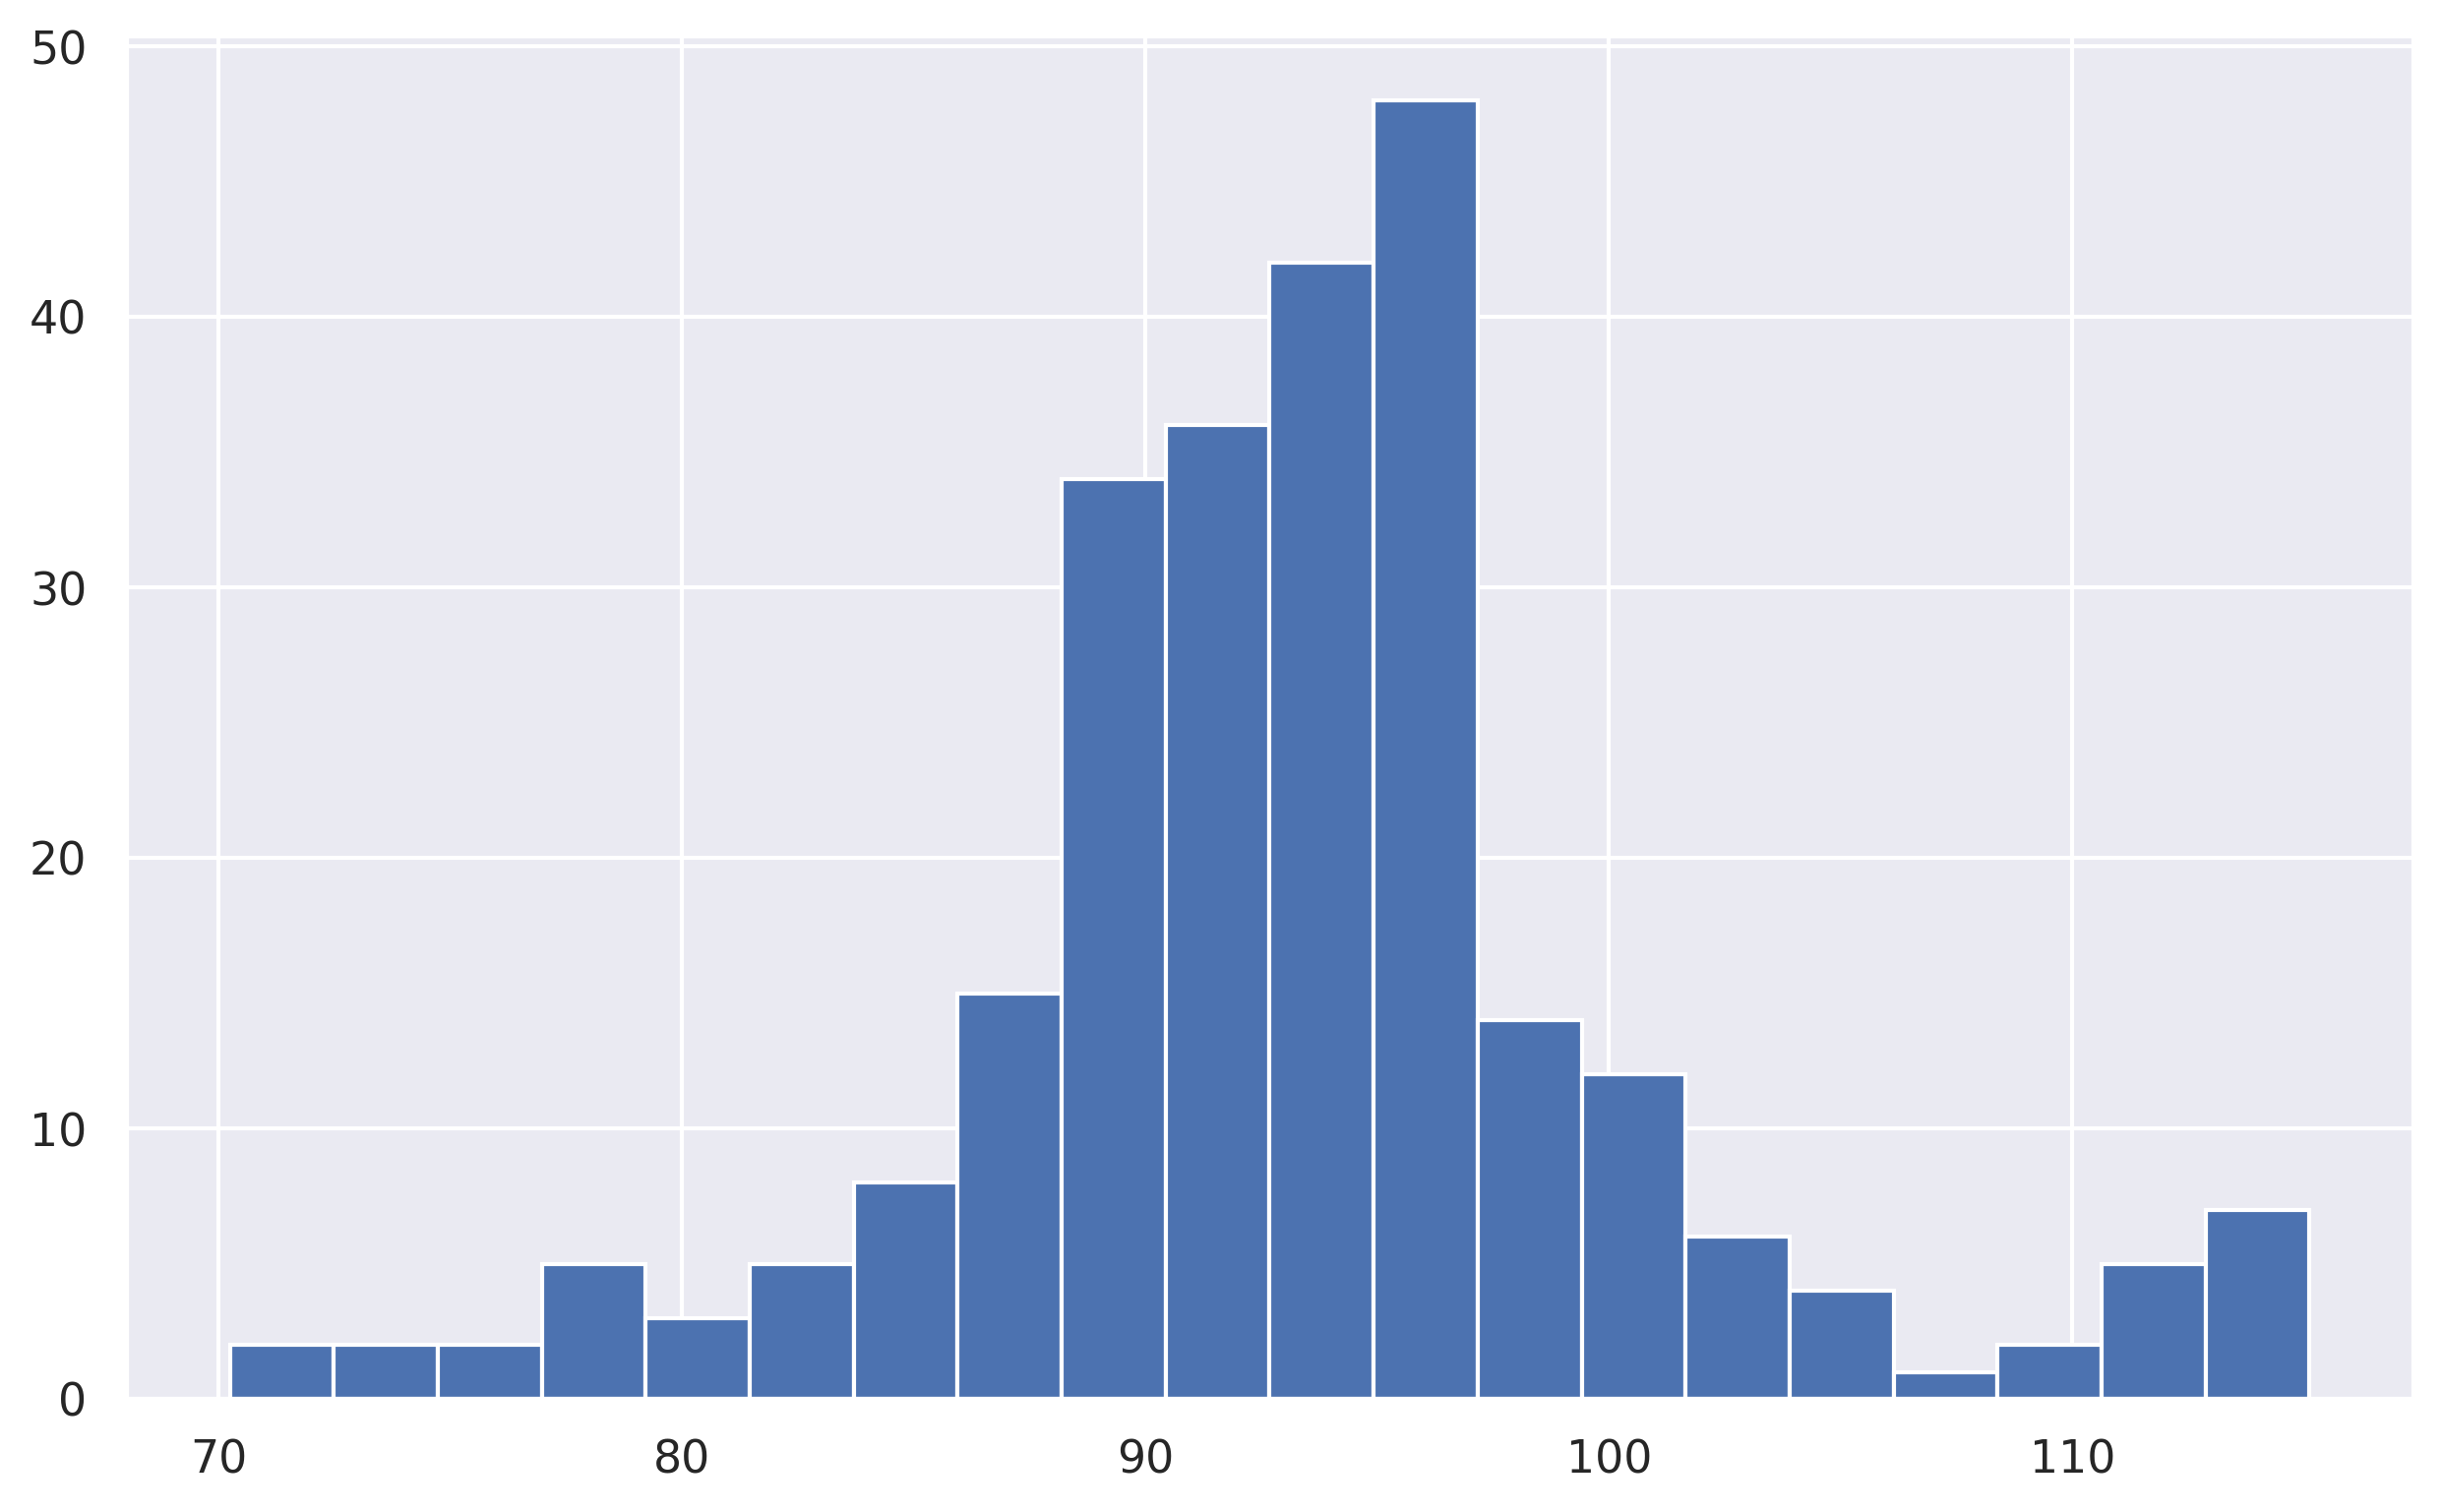

In [ ]:
stocks['IBM'].hist(bins=20)

Test di gaussianità, vedi [qui](https://chatgpt.com/share/698d837a-71b8-8012-b701-342413c309f9). Più utili istogrammi e boxplot.

Tuttavia, l'assunzione del VaR analitico è sulla gaussianità dei rendimenti, e non dei prezzi. Il logaritmo, usato per calcolare i rendimenti, li ha anche gaussianizzati, come si vede dalla seguente cella:

<Axes: >

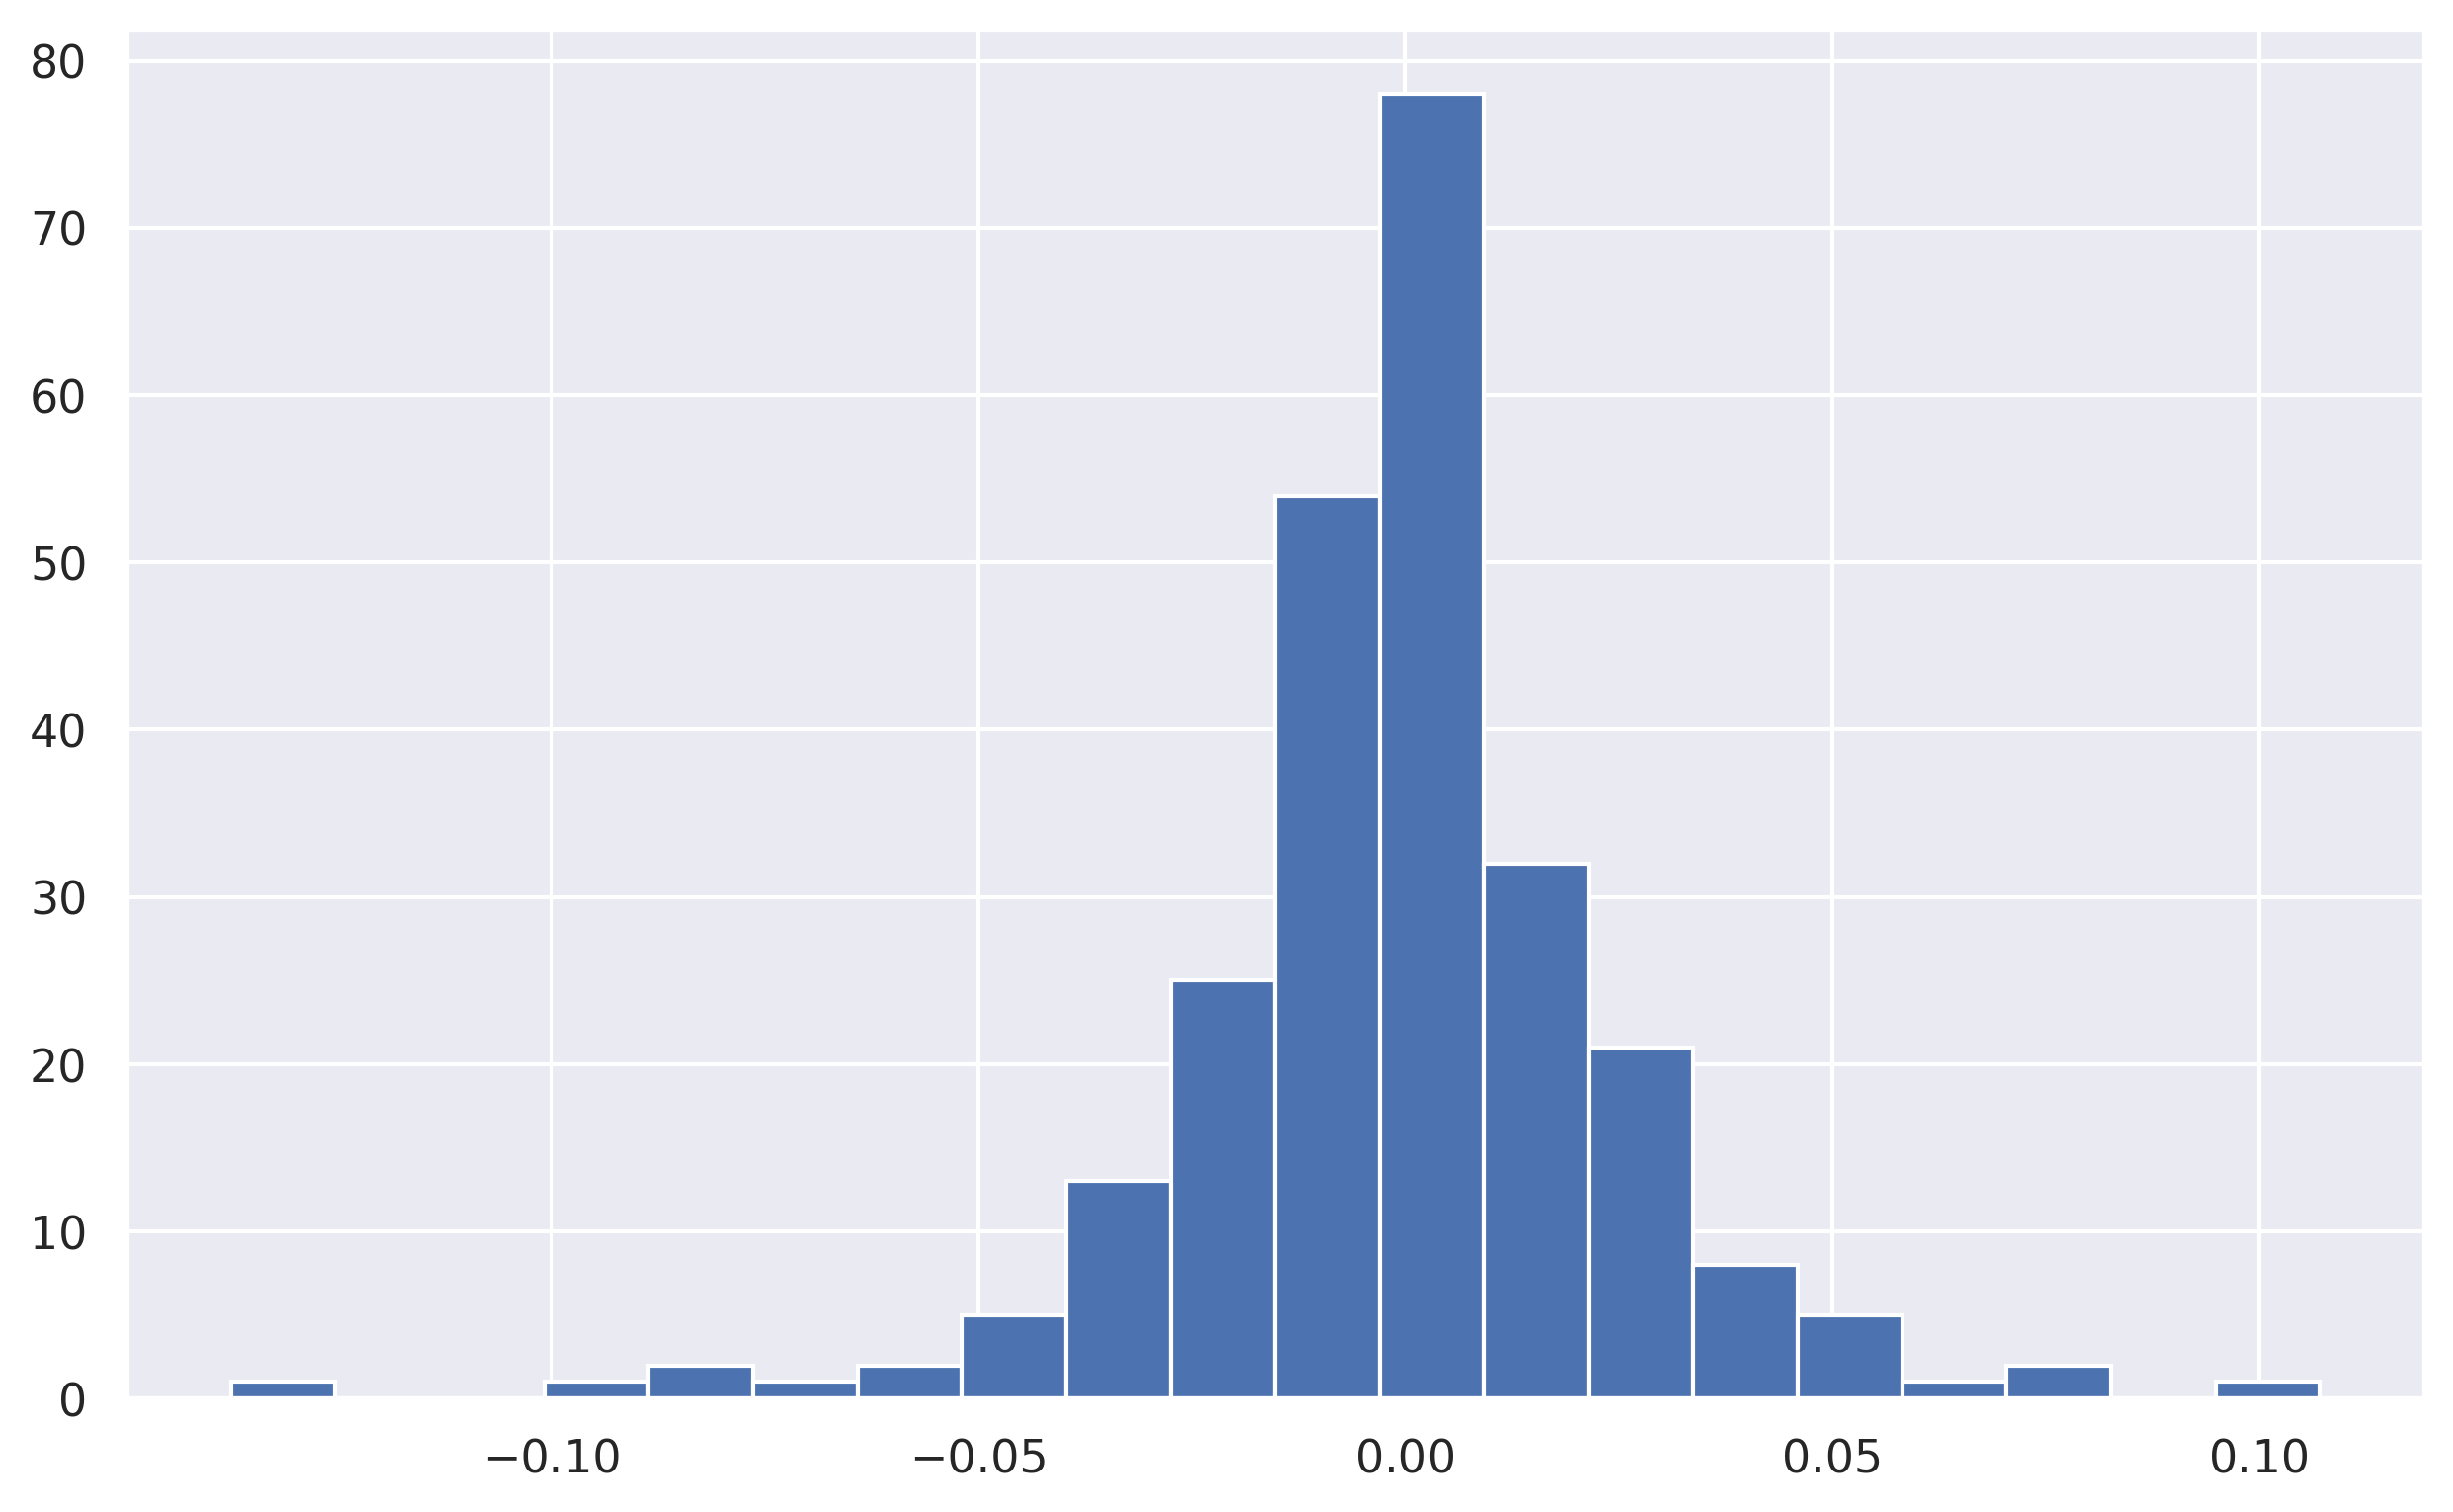

In [ ]:
stocks_returns['IBM'].hist(bins=20)  # --> il logaritmo ha fatto abbastanza bene il suo lavoro

Se i rendimenti sono gaussiani, lo è anche la loss (ed il VaR è un quantile della loss!) in quanto combinazione lineare dei rendimenti ($L_T=-W_0R_T$). Infatti, nella teoria della probabilità, se due o più variabili sono gaussiane, lo è anche la loro combinazione lineare, ad esempio 3X + 2Y.

## Il calcolo aritmetico dei rendimenti
[[torna ad indice]](#Indice)

Vediamo ora il secondo modo di calcolo dei rendimenti giornalieri dei titoli: quello aritmetico, e cioè:<br><br>
$$R_t = \frac{(P_t - P_{t-1})}{P_{t-1}}$$

Come detto prima, in Python questo modo di calcolo è implementato dal  metodo [`pct_change`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) di *pandas*, applicato ai **prezzi** (e non ai loro logaritmi!).

In [ ]:
stocks_2nd = stocks.pct_change()
stocks_2nd   # --> differenze al quinto decimale.

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,-0.007975,-0.012452,-0.012163
2020-01-06,-0.001787,0.002585,-0.002829
2020-01-07,0.000671,-0.009118,-0.016686
2020-01-08,0.008346,0.015928,0.000679
...,...,...,...
2020-12-24,0.006376,0.007827,0.010737
2020-12-28,0.001043,0.009921,0.000000
2020-12-29,-0.008172,-0.003601,0.049288


I due modi di calcolo, come si vede, differiscono solo al quinto decimale.

## Il calcolo del VaR analitico multivariato e multiperiodo (T>1)
[[torna ad indice]](#Indice)

Siamo adesso pronti per i calcoli finali.<br>

### La formula
[[torna ad indice]](#Indice)

La formula del VaR analitico multi-variato e multi-periodo (simile a quella del caso univariato e mono-periodo) e quella della varianza del portafoglio (la media non serve se l'orizzonte è breve) sono riporate qui sotto per il VaR nella versione di Brandimarte). Vedi anche la sezione *VaR analitico del portafoglio* nel notebook di teoria.

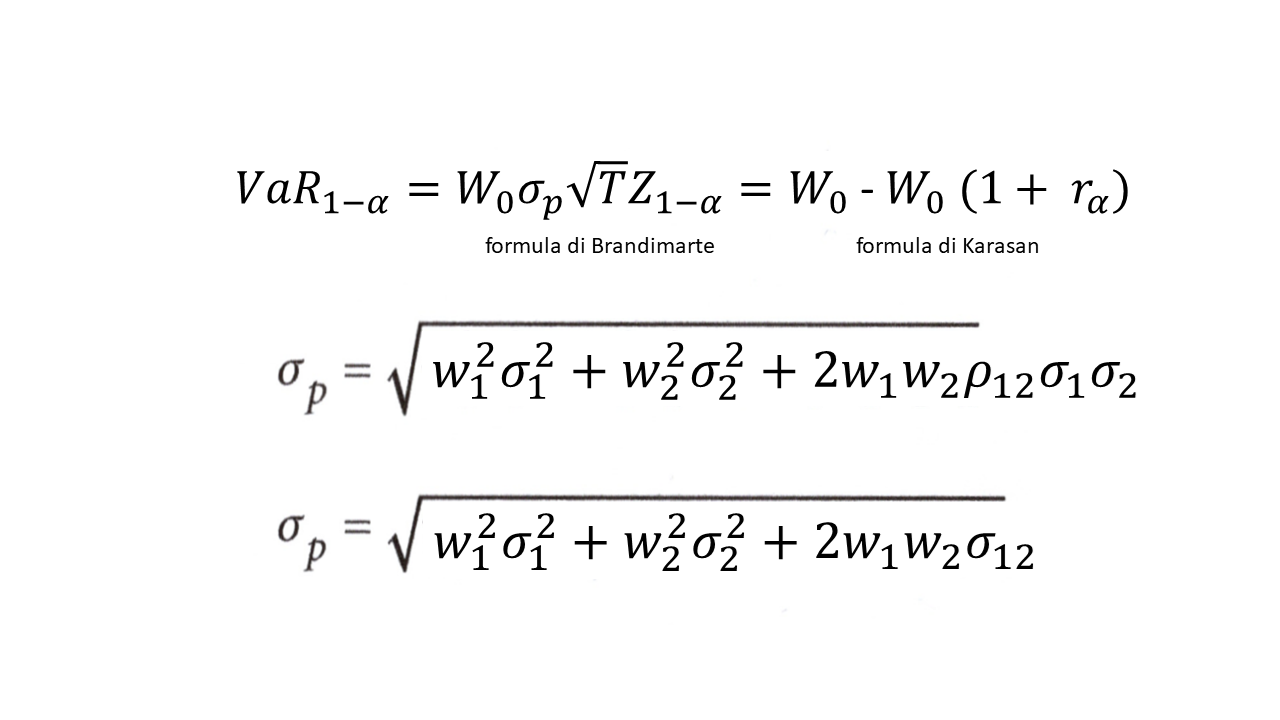

In [11]:
Image('mu_sigma_p_karasan.png',width=600) if IN_COLAB else display(Image(filename='mu_sigma_p_karasan.png'))

### L'inferenza
[[torna ad indice]](#Indice)

Quando la matrice di var-cov non è nota (a differenza dell'esempio 13:10 di prima), le **componenti** necessarie alla sua stima sono **inferite** dal campione (*weights* a parte, che sono in genere noti), che per prassi consolidata in ambito finanziario deve in questo caso avere <u>almeno un anno di dati</u>; esse sono utilizzabili anche per la **formula di Brandimarte**.<br>
Vediamo come avviene [l'inferenza](inference.png), in 4 passi:

In [ ]:
# 1.
stocks_returns_mean = stocks_returns.mean()                  # il vettore delle 3 medie dei dati (serve "solo" per il
                                                             # calcolo del VaR RELATIVO, utile per periodi T lunghi)

# 2.
# generazione casuale dei pesi del portafoglio con una tecnica tipica del mondo bancario:
np.random.seed(0)                                            # per garantire la ri-producibilità dei medesimi risultati;
                                                             # lo 0 è un numero come un altro, non ha significato.

weights  = np.random.random(len(stocks_returns.columns))     # estrazione casuale dei coefficienti di peso del portafoglio (da distribuzione uniforme standard)
weights /= np.sum(weights)                                   # generazione dei pesi effettivi (istruzione python per sovrascrivere i pesi con i pesi
                                                             # normalizzati a 1 (cioè ognuno diviso per la loro somma).
                                                             # shorthand assignment di Python: a /= b --> a = a / b
# 3.
cov_var = stocks_returns.cov()                               # calcolo della matrice var-cov (sui DATI - quanto pesa computazionalmente??)

# 4.
std_port = np.sqrt(weights.T.dot(cov_var).dot(weights))      # stima della dev std del portafoglio (vedi slide sigma di comb. lineare con correlazioni);
                                                             # è la consueta formula della sigma_p: il prodotto "interno" del vettore pesi trasposto
                                                             # (riga) per la matrice di var-cov per il vettore pesi (colonna). Il tutto sotto radice
                                                             # quadrata.

La cella precedente usa la versione semplificata delle assegnazioni Python (*shorthand assignment*), vedi [qui](https://www.geeksforgeeks.org/assignment-operators-in-python/).

Vediamo le **4 componenti** create:

In [ ]:
stocks_returns_mean           # 1. il vettore delle medie (non necessario in questo caso);
                              # ovviamente molto vicino al vettore di zeri perchè gaussianizzati

,0
IBM,-0.000088
MSFT,0.001334
INTC,-0.000696


In [ ]:
print(weights)                # 2. il vettore dei pesi (generato casualmente, avendo impostando prima il seed)
weights.sum()                 # è a somma 1

[0.29399155 0.38311672 0.32289173]


np.float64(0.9999999999999998)

In [ ]:
cov_var                       # 3. la matrice di varianza e covarianza (inferita)

,IBM,MSFT,INTC
IBM,0.000672,0.000463,0.000569
MSFT,0.000463,0.000770,0.000681
INTC,0.000569,0.000681,0.001159


In [ ]:
# la matrice di correlazione (inferita), se utile, è la stessa di prima, standardizzata:
mat_cor = stocks_returns.corr()
mat_cor

,IBM,MSFT,INTC
IBM,1.000000,0.643787,0.645060
MSFT,0.643787,1.000000,0.721121
INTC,0.645060,0.721121,1.000000


In [ ]:
std_port                      # 4. la dev std del portafoglio

np.float64(0.025938511080023898)

### La funzione python
[[torna ad indice]](#Indice)

Definiamo infine la **funzione** per il calcolo del VaR analitico.

In [ ]:
# la funzione calcola e visualizza il VaR dei tre asset separati e restituisce il VaR aggregato sul portafoglio
# (la loro somma), senza visualizzarlo.

def VaR_analytic(initial_investment, conf_level):

    alpha = norm.ppf(q = 1 - conf_level, loc = stocks_returns_mean, scale = std_port)
                                                                        # calcolo dei 3 quantili TEORICI (gli r_alpha di prima),
                                                                        # tramite la 'percent point function' (ppf).
                                                                        # NB. si usa qui il funzionamento VETTORIALE: poichè
                                                                        # 'stocks_returns_mean' è un vettore --> anche alpha
                                                                        # lo è!
                                                                        # NB: E' il quantile al livello di tolleranza alpha,
                                                                        # perchè (1-conf_level) = tolerance alpha.

    for i, j in zip(stocks.columns, range(len(stocks.columns))):        # zip parallelo su due "iterabili":
                                                                        # - il primo è il vettore dei nomi degli asset;
                                                                        # - il secondo è 'range(0,3)', cioè
                                                                        #   il vettore [0,1,2] delle iterazioni

        # print(alpha)                                                  # per debug

        # VaR del singolo asset (con la formula di Karasan)
        VaR_anal = (initial_investment - initial_investment *           # calcolo del VaR analitico (con la formula di
                                   (1 + alpha))[j]                      # Karasan) della iterazione corrente (j, da 0 a 2)

        print("Il Var analitico per {} è {:.0f} "                       # visualizzazione del nome dell'asset,
              .format(i, VaR_anal))                                     # CONTENUTO nel valore corrente di 'i', e del suo
                                                                        # VaR (della iterazione corrente)

    # VaR del portafoglio (con la formula di Karasan):
    VaR_anal = (initial_investment - initial_investment * (1 + alpha))  # --> il vettore dei tre VaR (gli stessi di prima);
                                                                        # anche qui si sfrutta il funzionamento vettoriale

    print('--' * 17)                                                    # display del separatore (linea tratteggiata)

    return VaR_anal                                                     # l'output della funzione (un vettore di 3 VaR)

I valori degli argomenti siano i seguenti:

In [ ]:
initial_investment = 1e6          # 1.000.000
conf_level = 0.95                 # livello di confidenza (tolleranza alpha = 0.05)

Il richiamo della funzione prima definita con gli argomenti valorizzati.

In [ ]:
VaR_analytic_ = VaR_analytic(initial_investment, conf_level)             # --> un vettore di 3 elementi (i 3 VaR di asset)
print("VaR del portafoglio: ", round(np.sum(VaR_analytic_),2))           # la visualizzazione del VaR aggregato (arrotondato)

Il Var analitico per IBM è 42753 
Il Var analitico per MSFT è 41331 
Il Var analitico per INTC è 43361 
----------------------------------
VaR del portafoglio:  127445.75


In [ ]:
42753+41331+43361

127445

NB. I tre VaR sono sommabili, ovvero il VaR del portafoglio è esattamente la somma dei 3 VaR individuali. Ogni singolo VaR, comunque, tiene conto del portafoglio perchè nella sua formula di calcolo è presente la deviazione standard del portafoglio.

La definizione della funzione ha fatto uso:
* della definizione di [**funzione** in Python](https://www.python.it/doc/Easytut/easytut-it/node9.html) tramite `def` ad inizio corpo, seguito dagli argomenti in input tra parentesi, e `return` a fine corpo, seguito dall'output della funzione; l'esito della chiamata della funzione è l'output;
* della funzione di *scipy* **`norm.ppf`**, già discussa prima, vedi [la sua documentazione ufficiale](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) ed anche [questo bel post](https://stackoverflow.com/questions/60699836/how-to-use-norm-ppf) per il suo utilizzo;
* della **vettorizzazione** di Python, cioè della sua capacità (come anche di R e Matlab) di eseguire in parallelo l'elaborazione delle componenti di un vettore; ad esempio:
    - `alpha` è un vettore di tre elementi perchè l'argomento `loc` della funzione `norm.ppf` ha **un vettore di 3 medie in input** (la funzione *ppf* altrimenti restituirebbe uno scalare!);  `std_port` è invece uno scalare;
    - così pure `VaR_anal` del portafoglio è un vettore di tre elementi perchè `alpha` è un vettore di tre elementi;
* della funzione [zip](https://realpython.com/python-zip-function/), che funziona appunto come una cerniera (lo zip!) iterando in parallelo su due [*iterabili*](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/Iterables.html) (i nomi degli asset e l'indice dell'iterazione). NB. I due indici *i* e *j* assumono **il valore del vettore indicizzato**; cioè, ad esempio, alla prima iterazione, *i* assume il valore *IBM*. Un solo indice per i due loop? vedi dopo
* delle funzioni `print` parametriche, nelle quali prima si specifica il prompt testuale intervallato dalle coppie di graffe come placeholder (segnaposto) dei vari parametri di stampa, e poi si riporta con il metodo `format` l'elenco dei valori dei parametri da stampare, nello stesso ordine del placeholder. `{:.xf}` significa *x* cifre decimali.
* della **indentazione del codice** per limitare il codice del ciclo `for` (a differenza di altri linguaggi, come *R*, che usano le coppie di {}. Vedi il PDF sottostante.
* della convenzione Python di identificare gli output di una funzione con lo *_* finale, qui per distinguere il nome della funzione dal suo output.

In [ ]:
# caricare il file PDF "Python Tips about Indentation.pdf"
if IN_COLAB:
  from google.colab import files
  uploaded = files.upload()  # si aprirà un prompt per caricare il PDF

Era possibile usare un solo indice nel loop precedente (anzichè la zip su due indici)? Sì, ma vediamo i risultati.

In [ ]:
# la stessa identica funzione di prima, con le stesse 4 componenti in input, ma con il solo indice 'i'
# --> 3 modifiche al codice di prima:

def VaR_analytic_prova(initial_investment, conf_level):

    alpha = norm.ppf(q = 1 - conf_level, loc = stocks_returns_mean, scale = std_port)

    for i in range(len(stocks.columns)):
    # 1. anzichè for i, j in zip(stocks.columns, range(len(stocks.columns))):

        VaR_anal = (initial_investment - initial_investment *
                                   (1 + alpha))[i]           # 2. [i] anzichè [j]

        print("Il Var analitico per {} è {:.0f} "
              .format(stocks.columns.values[i], VaR_anal))   # 3. anzichè:  .format(i, VaR_anal))

    VaR_anal = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 17)
    return VaR_anal

In [ ]:
VaR_analytic_ = VaR_analytic_prova(initial_investment, conf_level)             # --> un vettore di 3 elementi (i 3 VaR di asset)
print("VaR del portafoglio: ", round(np.sum(VaR_analytic_),2))           # la visualizzazione del VaR aggregato (arrotondato)

Il Var analitico per IBM è 42753 
Il Var analitico per MSFT è 41331 
Il Var analitico per INTC è 43361 
----------------------------------
VaR del portafoglio:  127445.75


Stesso identico output, ma con **un codice meno corretto** dal punto di vista della programmazione.<br>
Quindi NON usare la funzione `VaR_analytic_prova`.

### Il VaR analitico multiperiodo
[[torna ad indice]](#Indice)

Finora abbiamo usato T=1. **Il VaR cambia a seconda dell'orizzonte temporale**, poichè una detenzione di un titolo (da parte di un investitore) prolungata nel tempo aumenta il rischio per l'investitore, come mostrato dal plot sottostante.<br>
Il plot sottostante NON deve ricalcolare i VaR, ma semplicemente moltiplicarli per $\sqrt(t)$

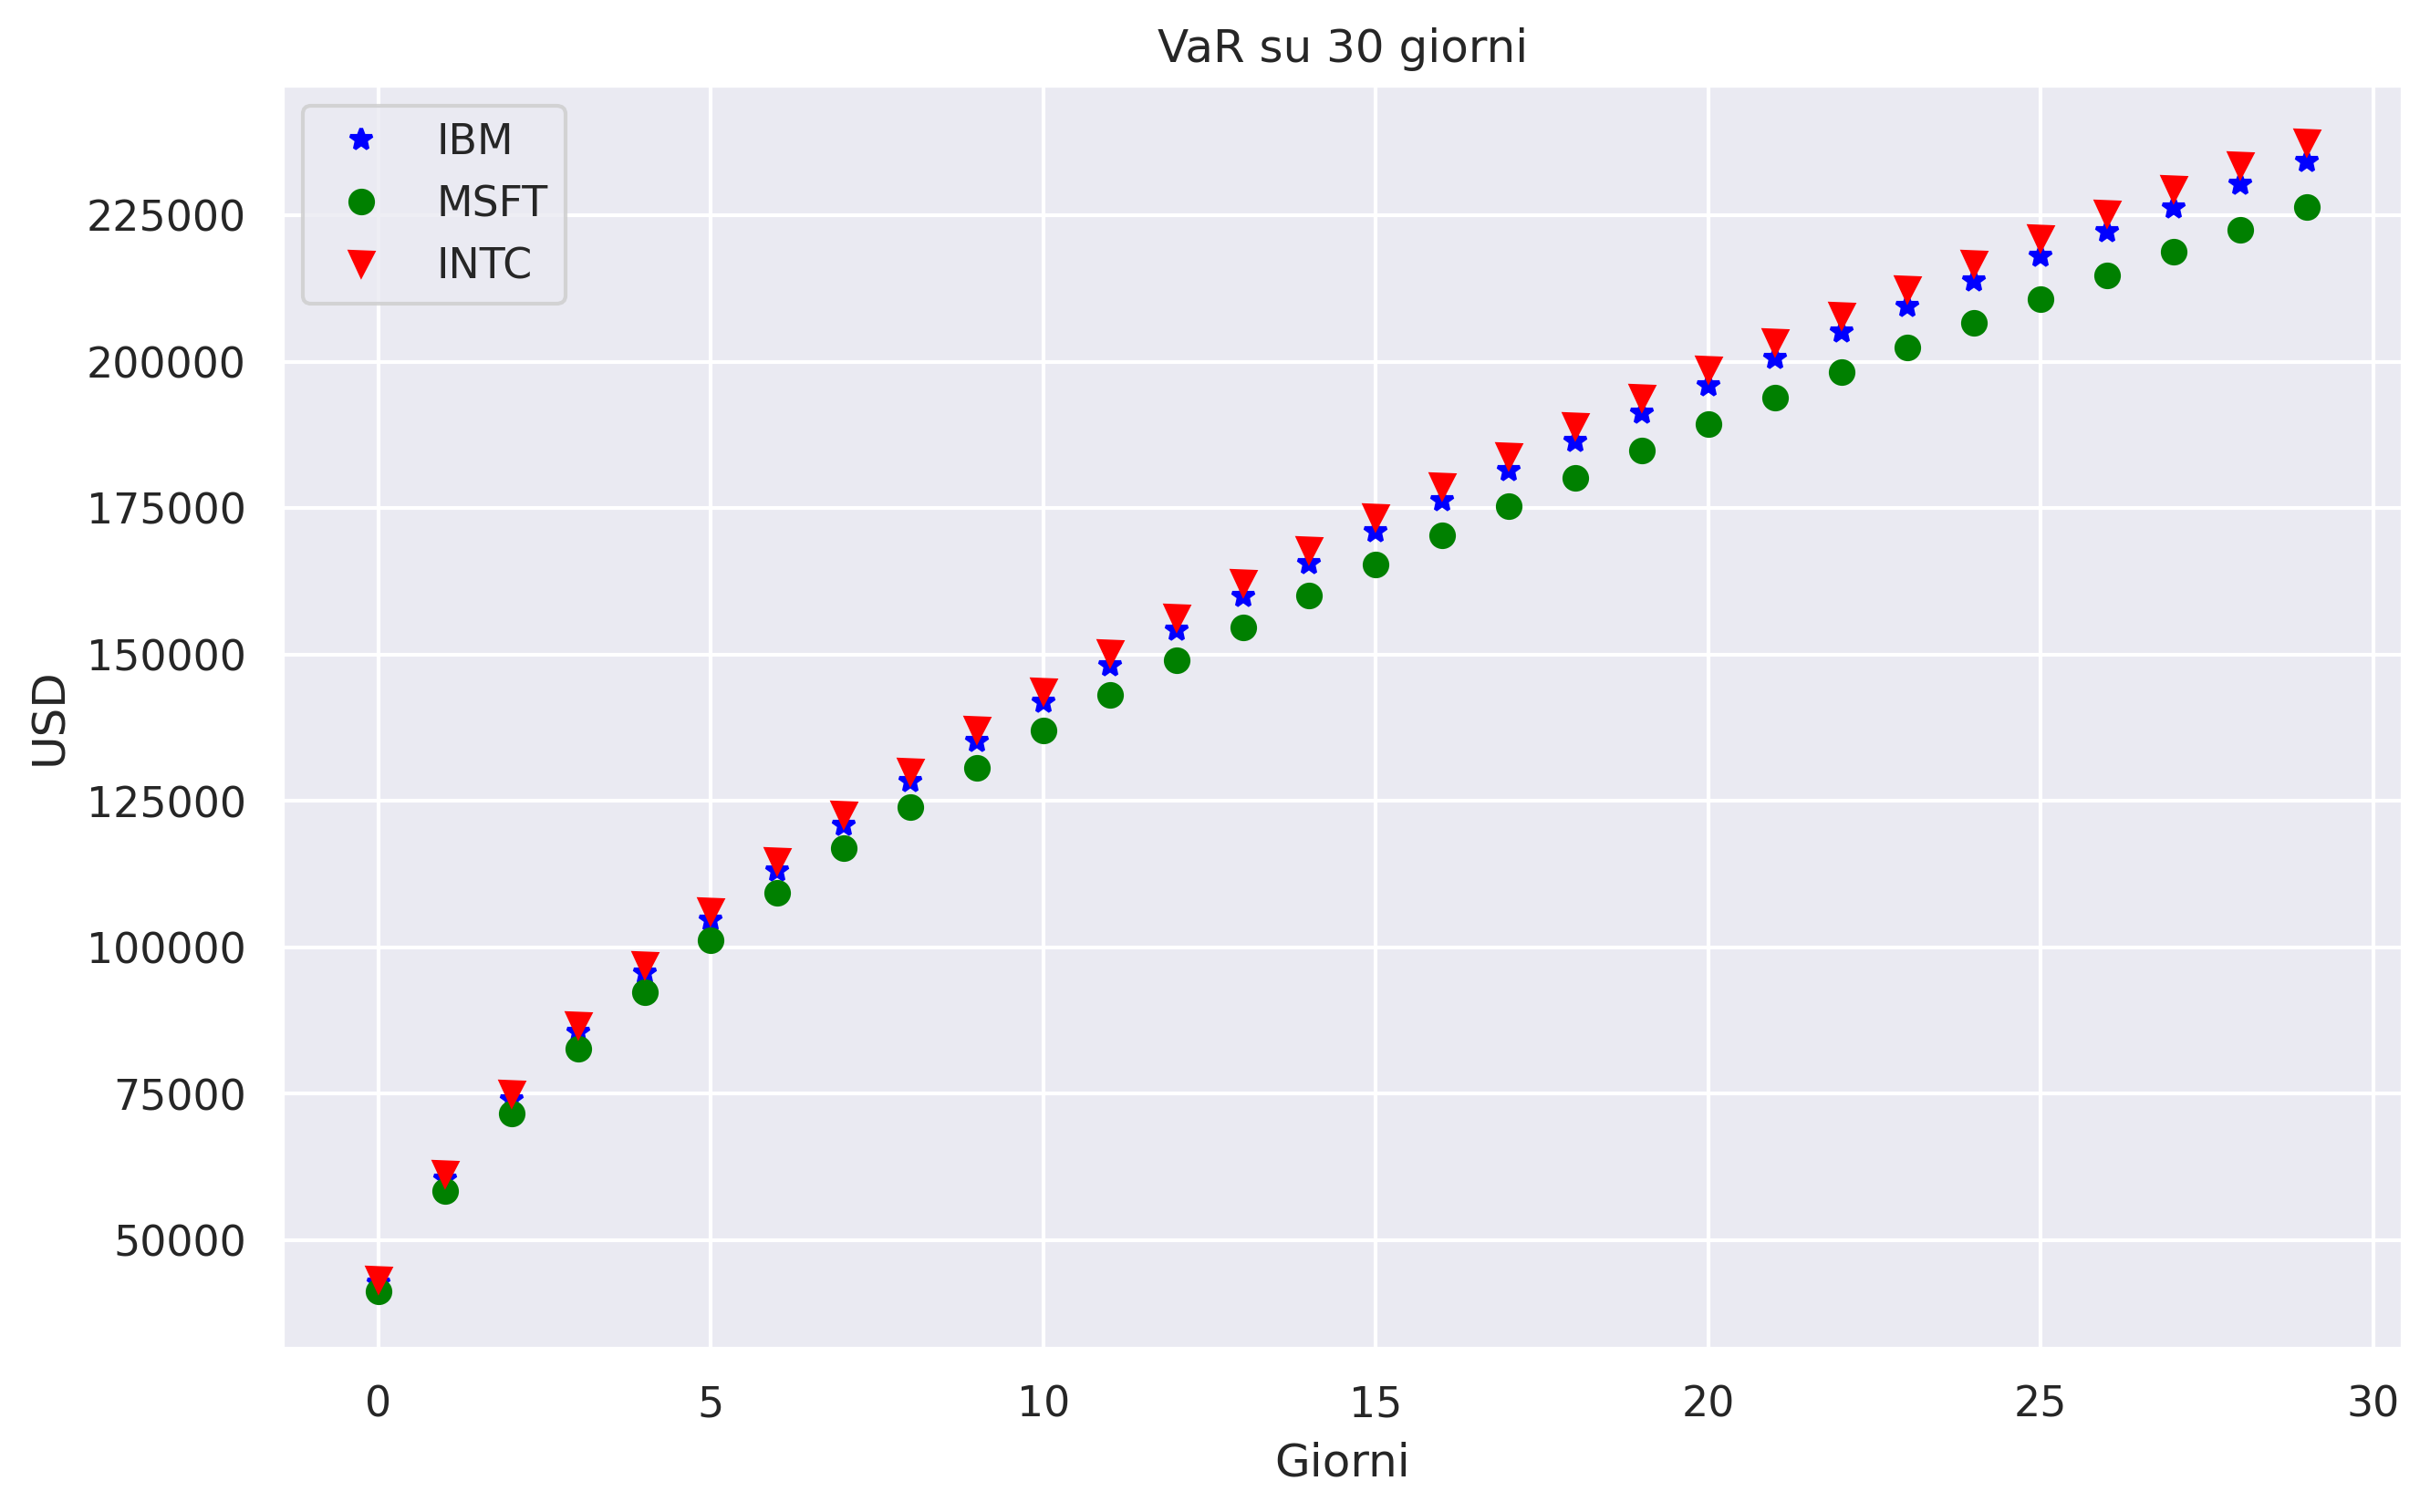

In [ ]:
T = 30                                                            # T=30 periodi (un buon valore per un investitore)

var_horizon = []                                                  # inizializzazione del vettore dei T VaR

# calcolo dei VaR:
for j in range(len(stocks_returns.columns)):                      # ciclo esterno sugli asset
    for i in range(1, T + 1):                                     # ciclo interno sul periodo

        var_horizon.append(VaR_analytic_[j] * np.sqrt(i))         # il VaR analitico dell'asset. calcolato prima,
                                                                  # moltiplicato per la radice quadrata di T

# plot delle tre serie temporali di VaR:
plt.plot(var_horizon[:T], "o",
         c='blue', marker='*', label='IBM')                       # colore, marker e label specifici per IBM
plt.plot(var_horizon[T:T + 30], "o",
         c='green', marker='o', label='MSFT')                     # colore, marker e label specifici per Microsoft
plt.plot(var_horizon[T + 30:T + 60], "o",
         c='red', marker='v', label='INTC')                       # colore, marker e label specifici per Intel

plt.xlabel("Giorni")
plt.ylabel("USD")
plt.title("VaR su 30 giorni")
plt.legend()
plt.show()


Come si vede dal plot, il VaR cresce proporzionalmente a $\sqrt{T}$, **se i rendimenti sono iid** (Clifford Ang, p. 125).<br>
**Lo sono nel nostro caso?**

### Rendimenti autocorrelati?
[[torna ad indice]](#Indice)

Dobbiamo anche verificare <u>un'altra assunzione</u> dietro al VaR analitico: che i rendimenti del **singolo titolo** (nel nostro caso il datframe `stocks_returns['*']`) non siano auto-correlati, cioè **correlati tra di loro**.<br>

[In realtà la condizione da verificare è l'indipendenza, che però nel caso gaussiano si riduce alla mancanza di correlazione].<br>

Alcuni esempi tipici</u> di auto-correlazione: trend lineare (cioè se il rendimento di un titolo è aumentato negli ultimi X giorni, in base alla serie storica si evince che probabilmente il rendimento aumenterà anche oggi), stagionalità, trend sinosoidale .<br>
Ci sono molti modi per calcolare l'eventuale (probabile?!) auto-correlazione (campionaria) dei rendimenti di un titolo, vedi ad esempio [qui](https://www.geeksforgeeks.org/how-to-calculate-autocorrelation-in-python/). Useremo il [correlogramma](https://it.wikipedia.org/wiki/Correlogramma) visualizzato dalla funzione [plot_acf()](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) di `statsmodels`.<br>
ACF sta per Auto-Correlation Function:

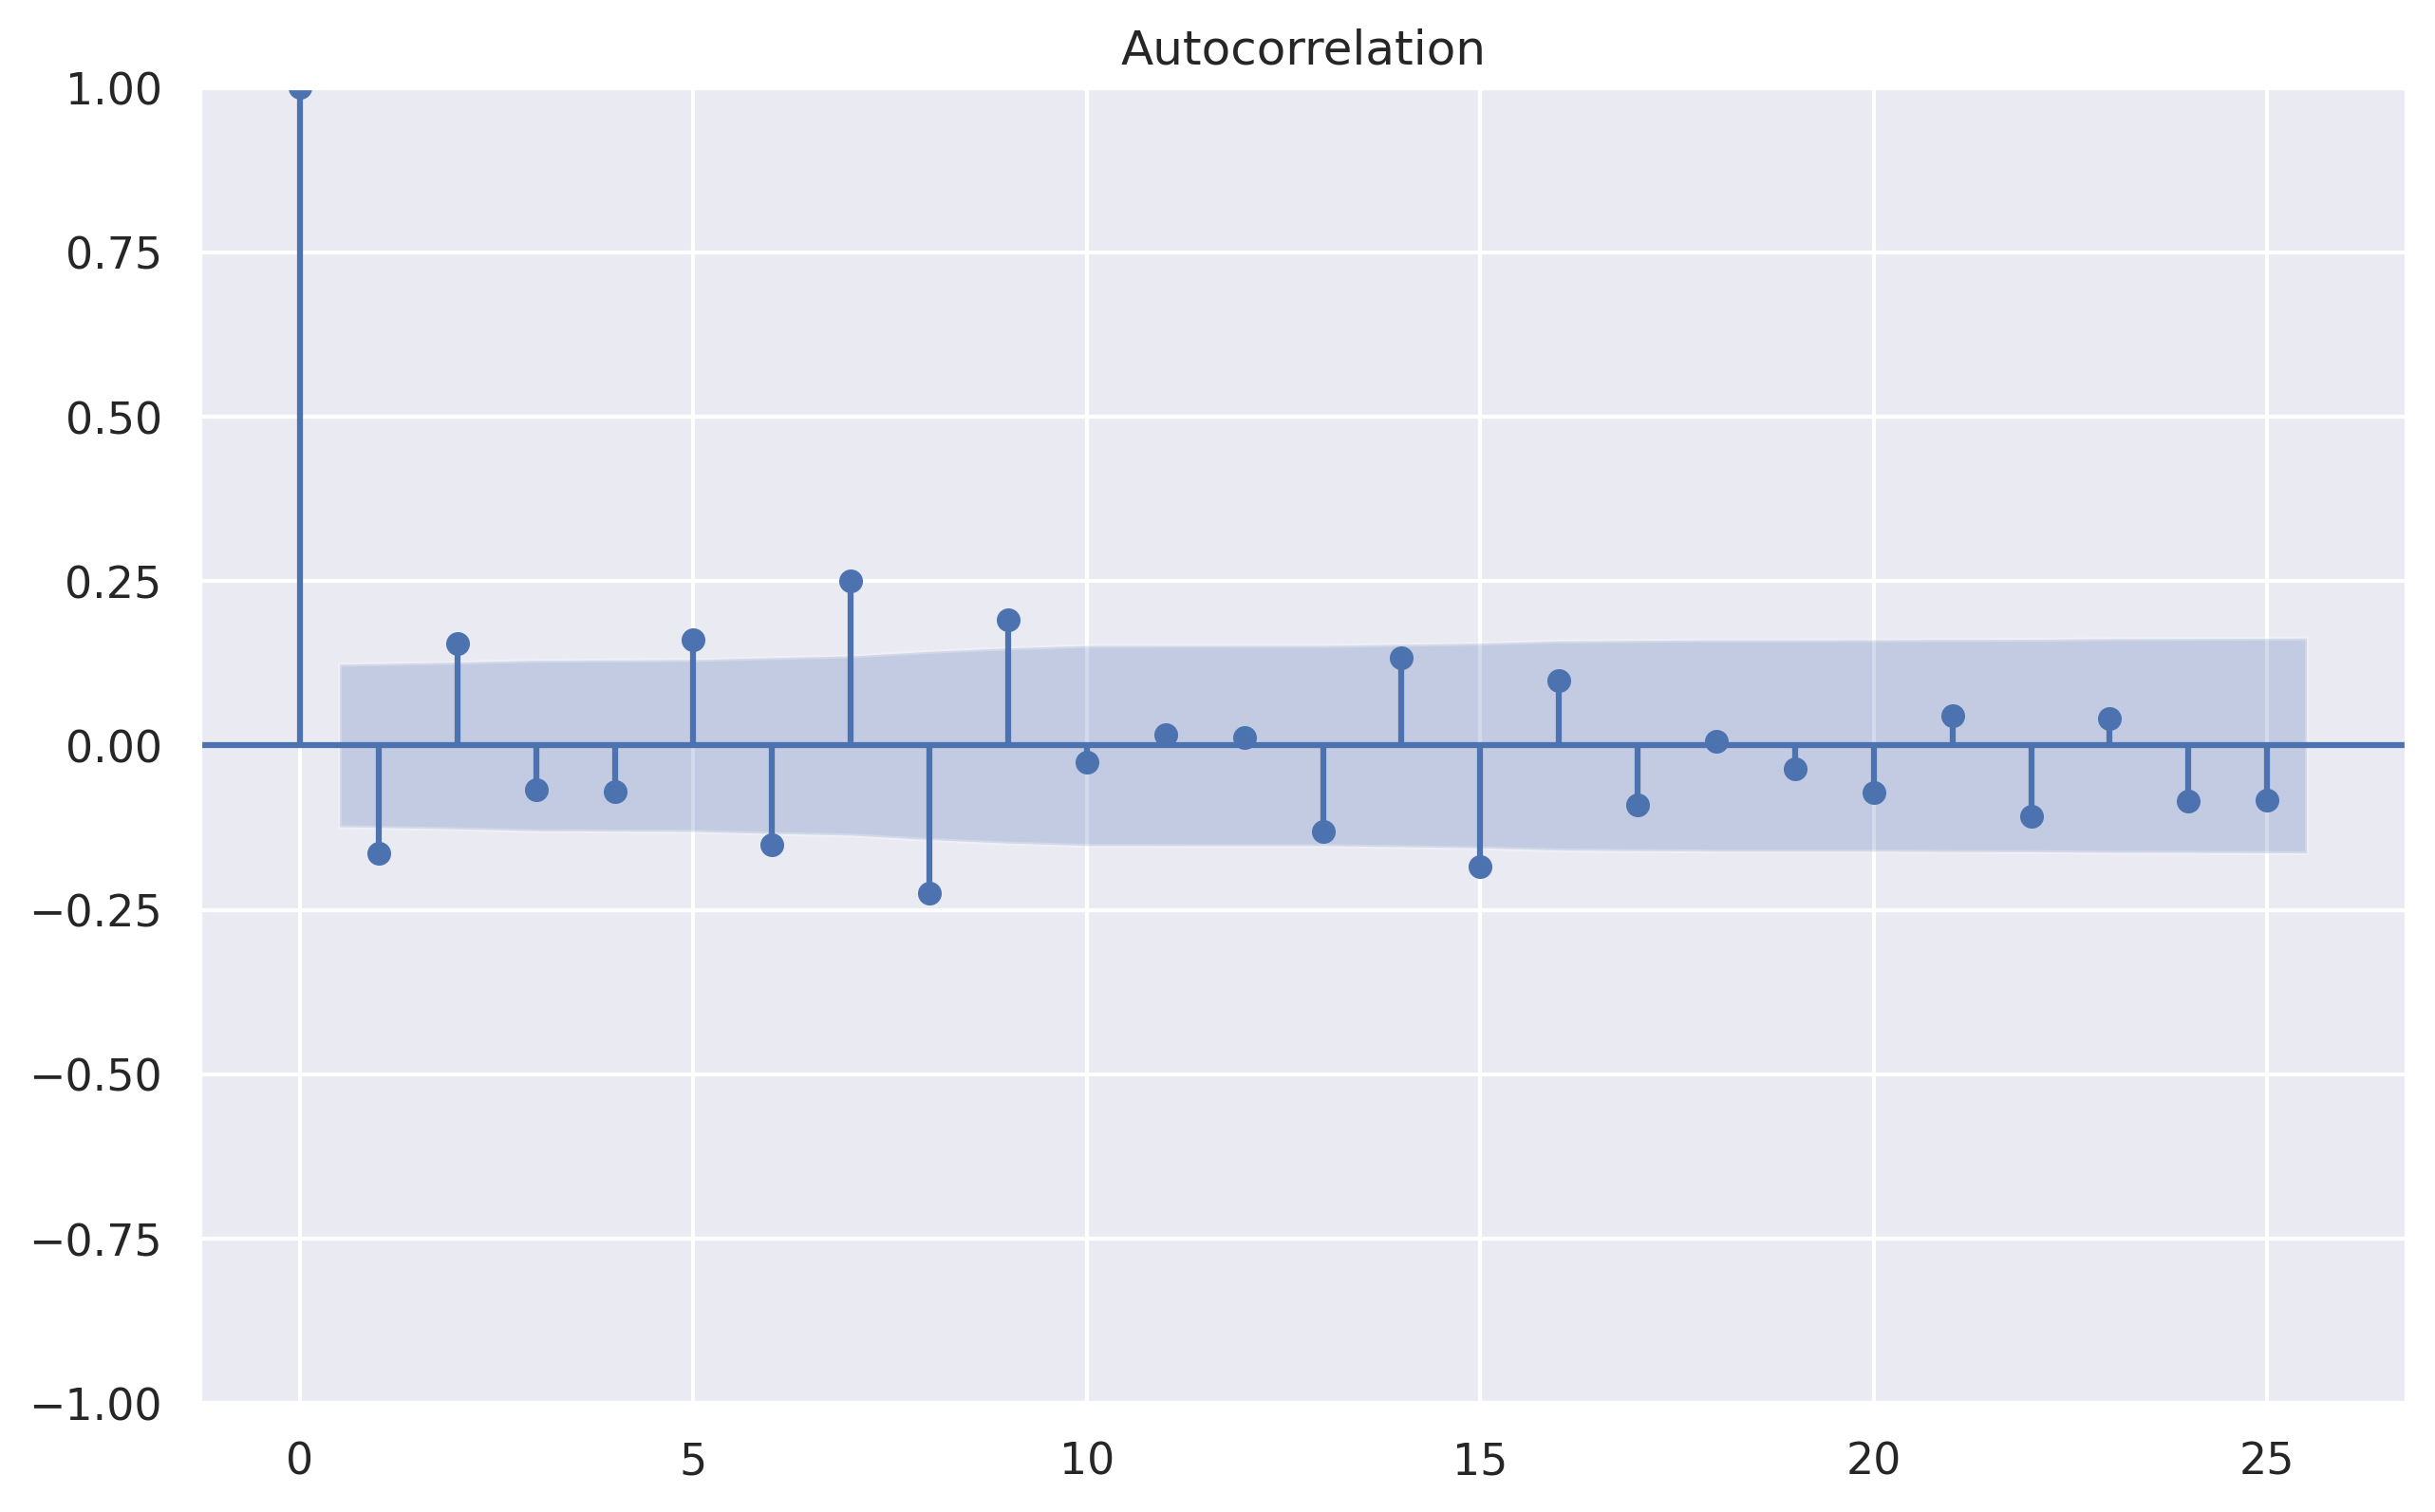

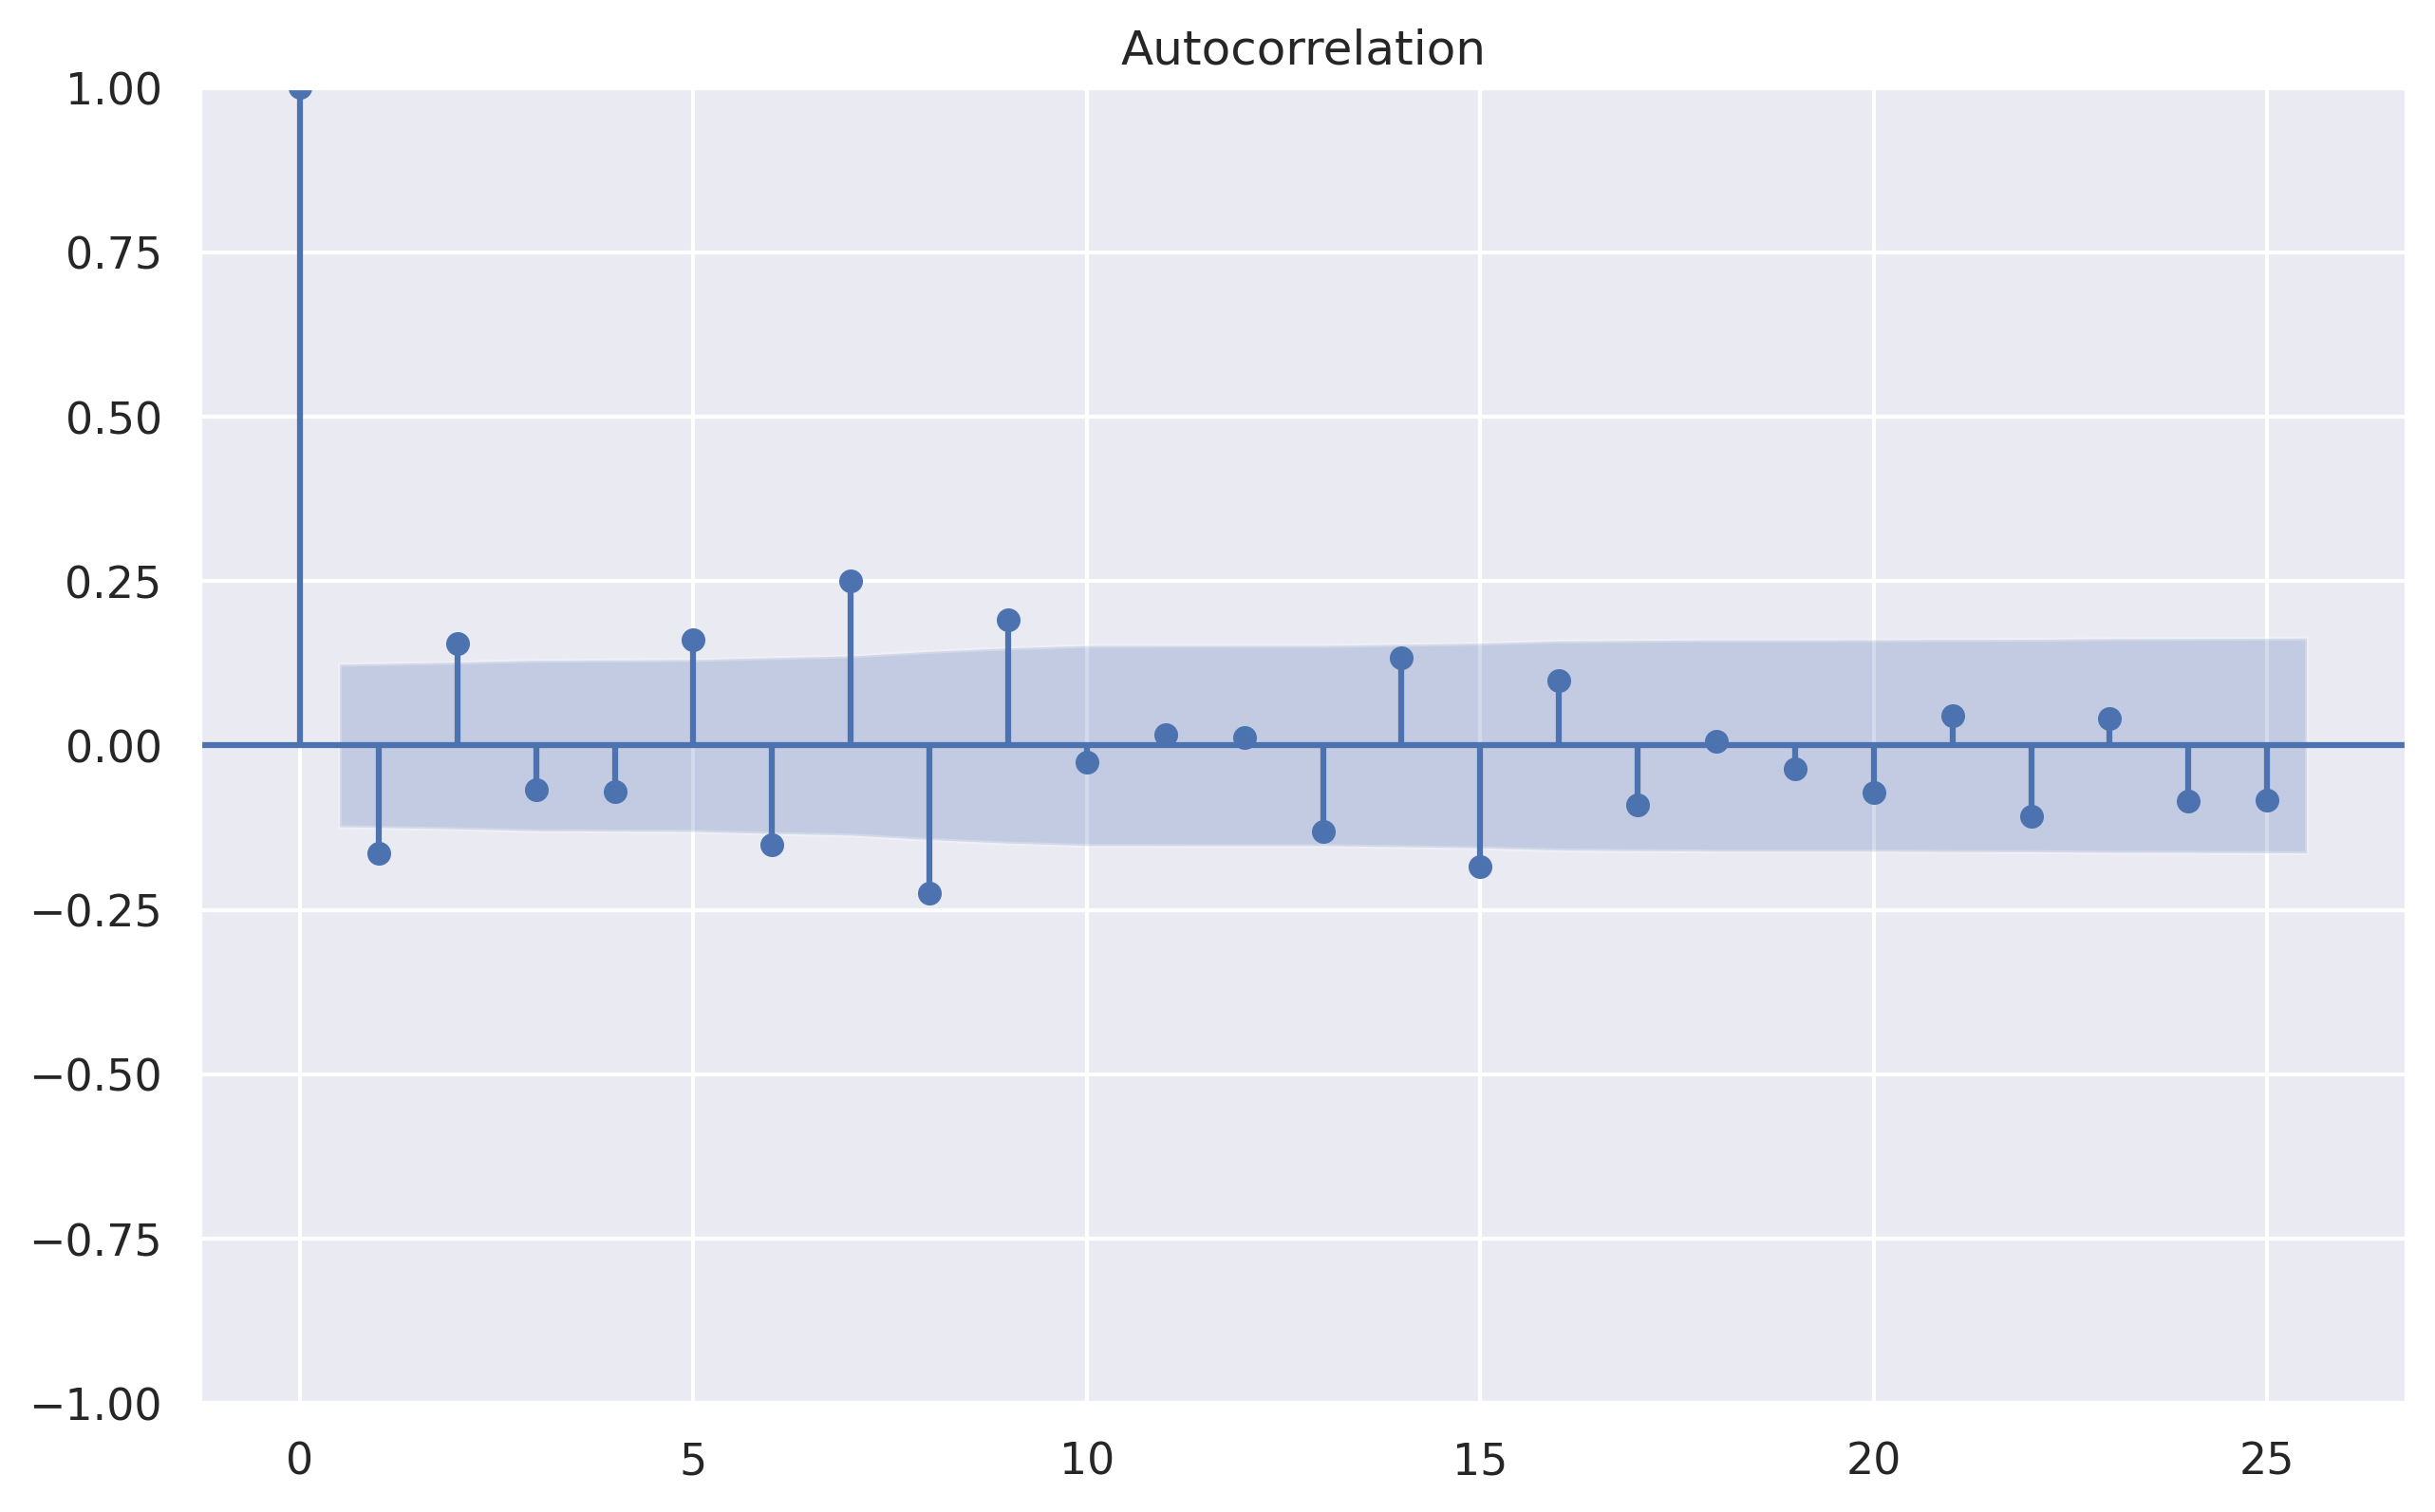

In [ ]:
# plot the auto correlation
plot_acf(stocks_returns['IBM'])

Il plot mostra le correlazioni tra la serie storica originale e quelle ritardate di k periodi. La prima è ovviamente 1. La fascia blu indica la banda di non-significatività, oltre la quale cioè l'ipotesi di test H0 (no-correlazione tra le due serie) non può essere accettata per quel livello di confidenza $(1-\alpha)$. Bene, il titolo IBM **non** sembra particolarmente auto-correlato nel tempo (siamo infatti nel terzo caso descritto dalla voce *Correlogramma* di Wikipedia IT prima linkata). Analogamente per gli altri due titoli (*MSFT* e *INTC*).<br>
Il numero *k* ha un massimo di 25 giorni al fine di non ridurre troppo il numero di confronti (in genere è comunque $k < T/4$).

## VaR analitico con la distribuzione *t di Student*
[[torna ad indice]](#Indice)

Si usano le stesse 4 componenti in input di prima (medie dei rendimenti, pesi del portafoglio, matrice var-cov del portafoglio, dev-std del portafoglio), ma i quantili sono quelli della distribuzione [*t di Student*](https://it.wikipedia.org/wiki/Distribuzione_t_di_Student).<br>
Vedi [qui](https://stackoverflow.com/questions/67340028/how-to-use-t-ppf-which-are-the-arguments) per l'uso della funzione *t.ppf*.

In [ ]:
def VaR_analytic_t(initial_investment, conf_level):

    alpha = t.ppf(q = 1 - conf_level, df = stocks.shape[0], loc = stocks_returns_mean, scale = std_port)

    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_anal = (initial_investment - initial_investment *
                                   (1 + alpha))[j]
        print("Il Var analitico per {} è {} "
              .format(i, VaR_anal))

    # VaR del portafoglio:
    VaR_anal = (initial_investment - initial_investment * (1 + alpha))

    print('--' * 25)

    return VaR_anal

In [ ]:
VaR_analytic_t_ = VaR_analytic_t(initial_investment, conf_level)
print("VaR del portafoglio: ", round(np.sum(VaR_analytic_t_),2))

Il Var analitico per IBM è 42910.03370633011 
Il Var analitico per MSFT è 41488.2526775148 
Il Var analitico per INTC è 43517.86156171886 
--------------------------------------------------
VaR del portafoglio:  127916.15


I VaR sono leggermente superiori a quelli gaussiani (ma troppo poco!).

## Il VaR simulato in modo storico
[[torna ad indice]](#Indice)

Il calcolo del VaR storico richiede 3-5 anni di storia, come detto. Dunque:
* carichiamo da *Alpha Vantage* un dataset **multi-anno (anzichè solo del 2020, come prima)**, sempre di nome `stocks`
* e trasformiamo i prezzi di chiusura aggiustata in rendimenti logaritmici, come visto prima:

In [ ]:
# passo 1: caricamento da alpha vantage:
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock3.append(getDailyData(symbol)[::-1]['adjusted_close']
                  ['2018-01-01': '2023-12-31'])         # caricamento dei 6 anni (unica differenza con la cella
                                                        # dell'altra sezione)
stocks = pd.DataFrame(stock3).T
stocks.columns = symbols
stocks.head()

,IBM,MSFT,INTC
timestamp,,,
2018-01-02,103.260535,79.035827,39.338944
2018-01-03,106.098944,79.403649,38.003855
2018-01-04,108.247834,80.102512,37.306922
2018-01-05,108.776689,81.095632,37.567222
2018-01-08,109.432736,81.178392,37.567222


**Alternativamente**, in caso di indisponibilità della connessione internet, possiamo caricare il dataframe da questo **file *csv***:

In [ ]:
# passo 1: caricamento da file csv
stocks = pd.read_csv("alpha_vantage_2018_2023.csv")
stocks.set_index('timestamp',inplace=True)   # è qui necessario creare esplicitamente l'indice sulla colonna 'timestamp',
                                             # che la funzione 'pd.DataFrame' aveva invece prima creato automaticamente.
                                             # la funzione 'pd.read_csv' non lo fa.
print(stocks.head())
print(stocks.tail())

FileNotFoundError: [Errno 2] No such file or directory: 'alpha_vantage_2018_2023.csv'

In [ ]:
# passo 2: trasformazione dei prezzi in rendimenti logaritmici:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

,IBM,MSFT,INTC
timestamp,,,
2018-01-03,0.027117,0.004643,-0.034527
2018-01-04,0.020051,0.008763,-0.018509
2018-01-05,0.004874,0.012322,0.006953
2018-01-08,0.006013,0.001020,0.000000
2018-01-09,0.002200,-0.000680,-0.025352
...,...,...,...
2023-12-22,0.008423,0.002780,0.019353
2023-12-26,0.006578,0.000214,0.050772
2023-12-27,0.001531,-0.001576,0.005135


Diamo un'occhiata (EDA!) a questi rendimenti storici, plottando l'istogramma e la [CDF empirica](https://en.wikipedia.org/wiki/Empirical_distribution_function) del titolo IBM:

<Axes: >

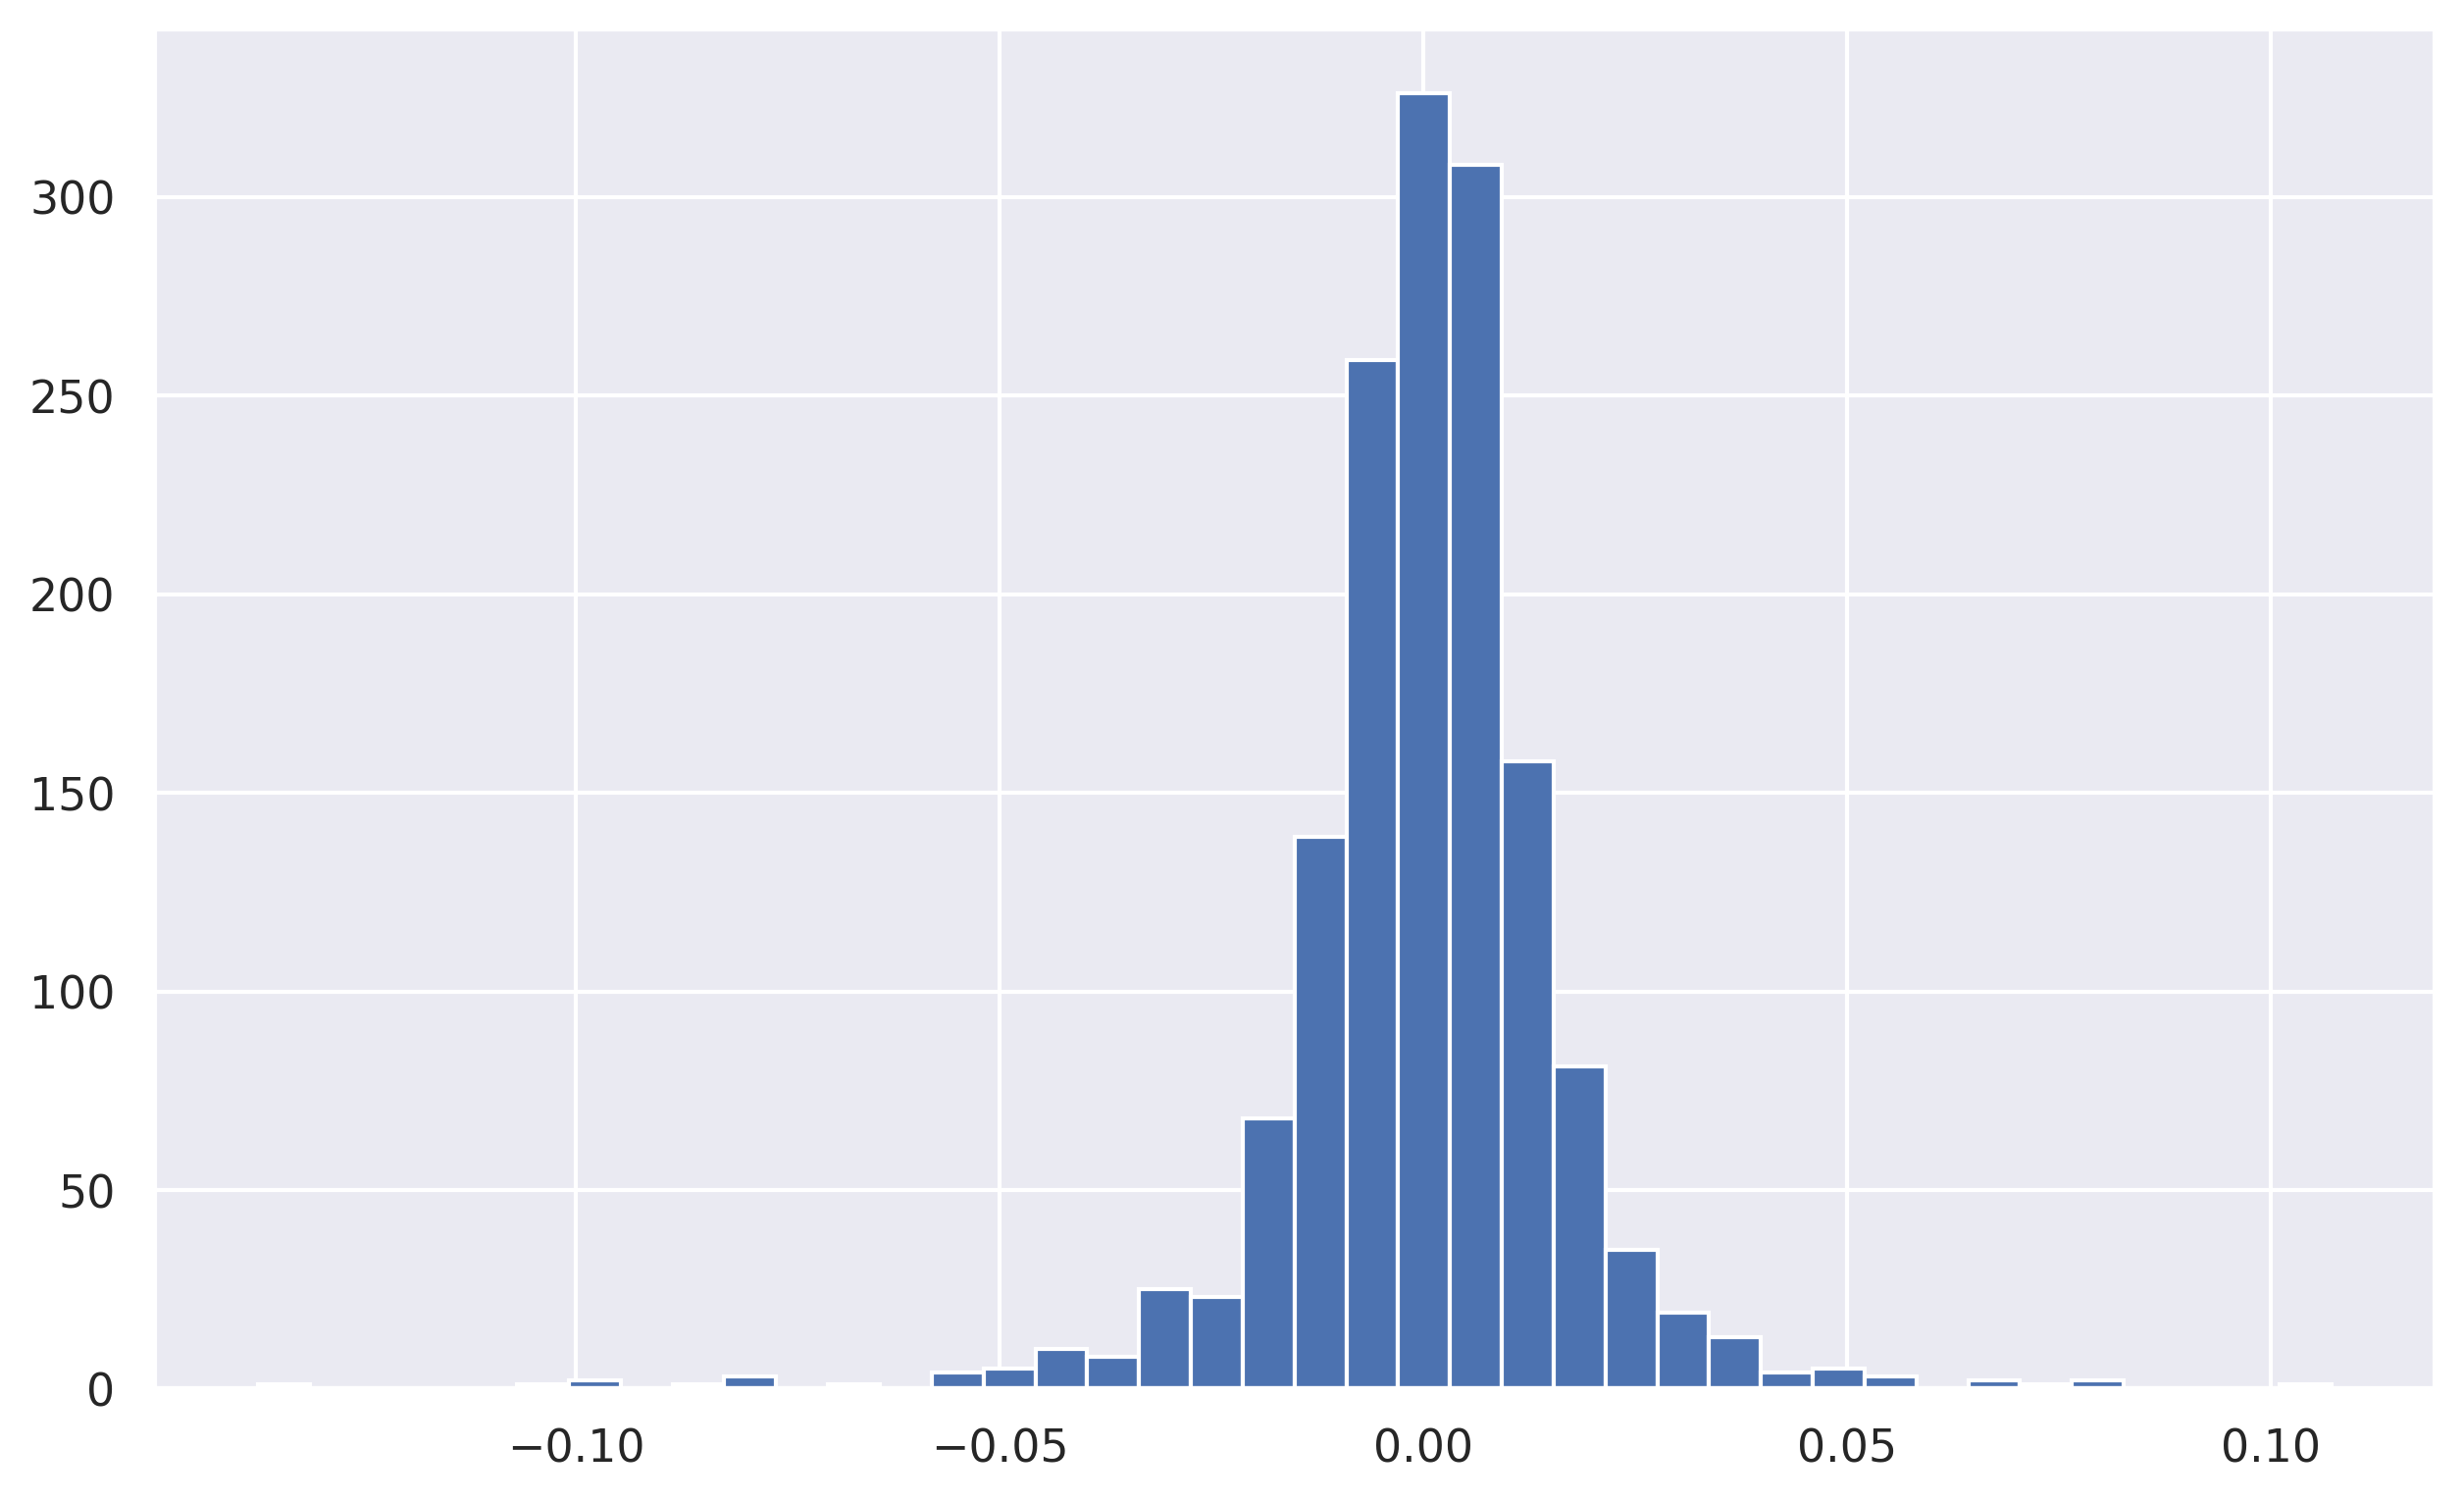

In [ ]:
stocks_returns['IBM'].hist(bins=40)

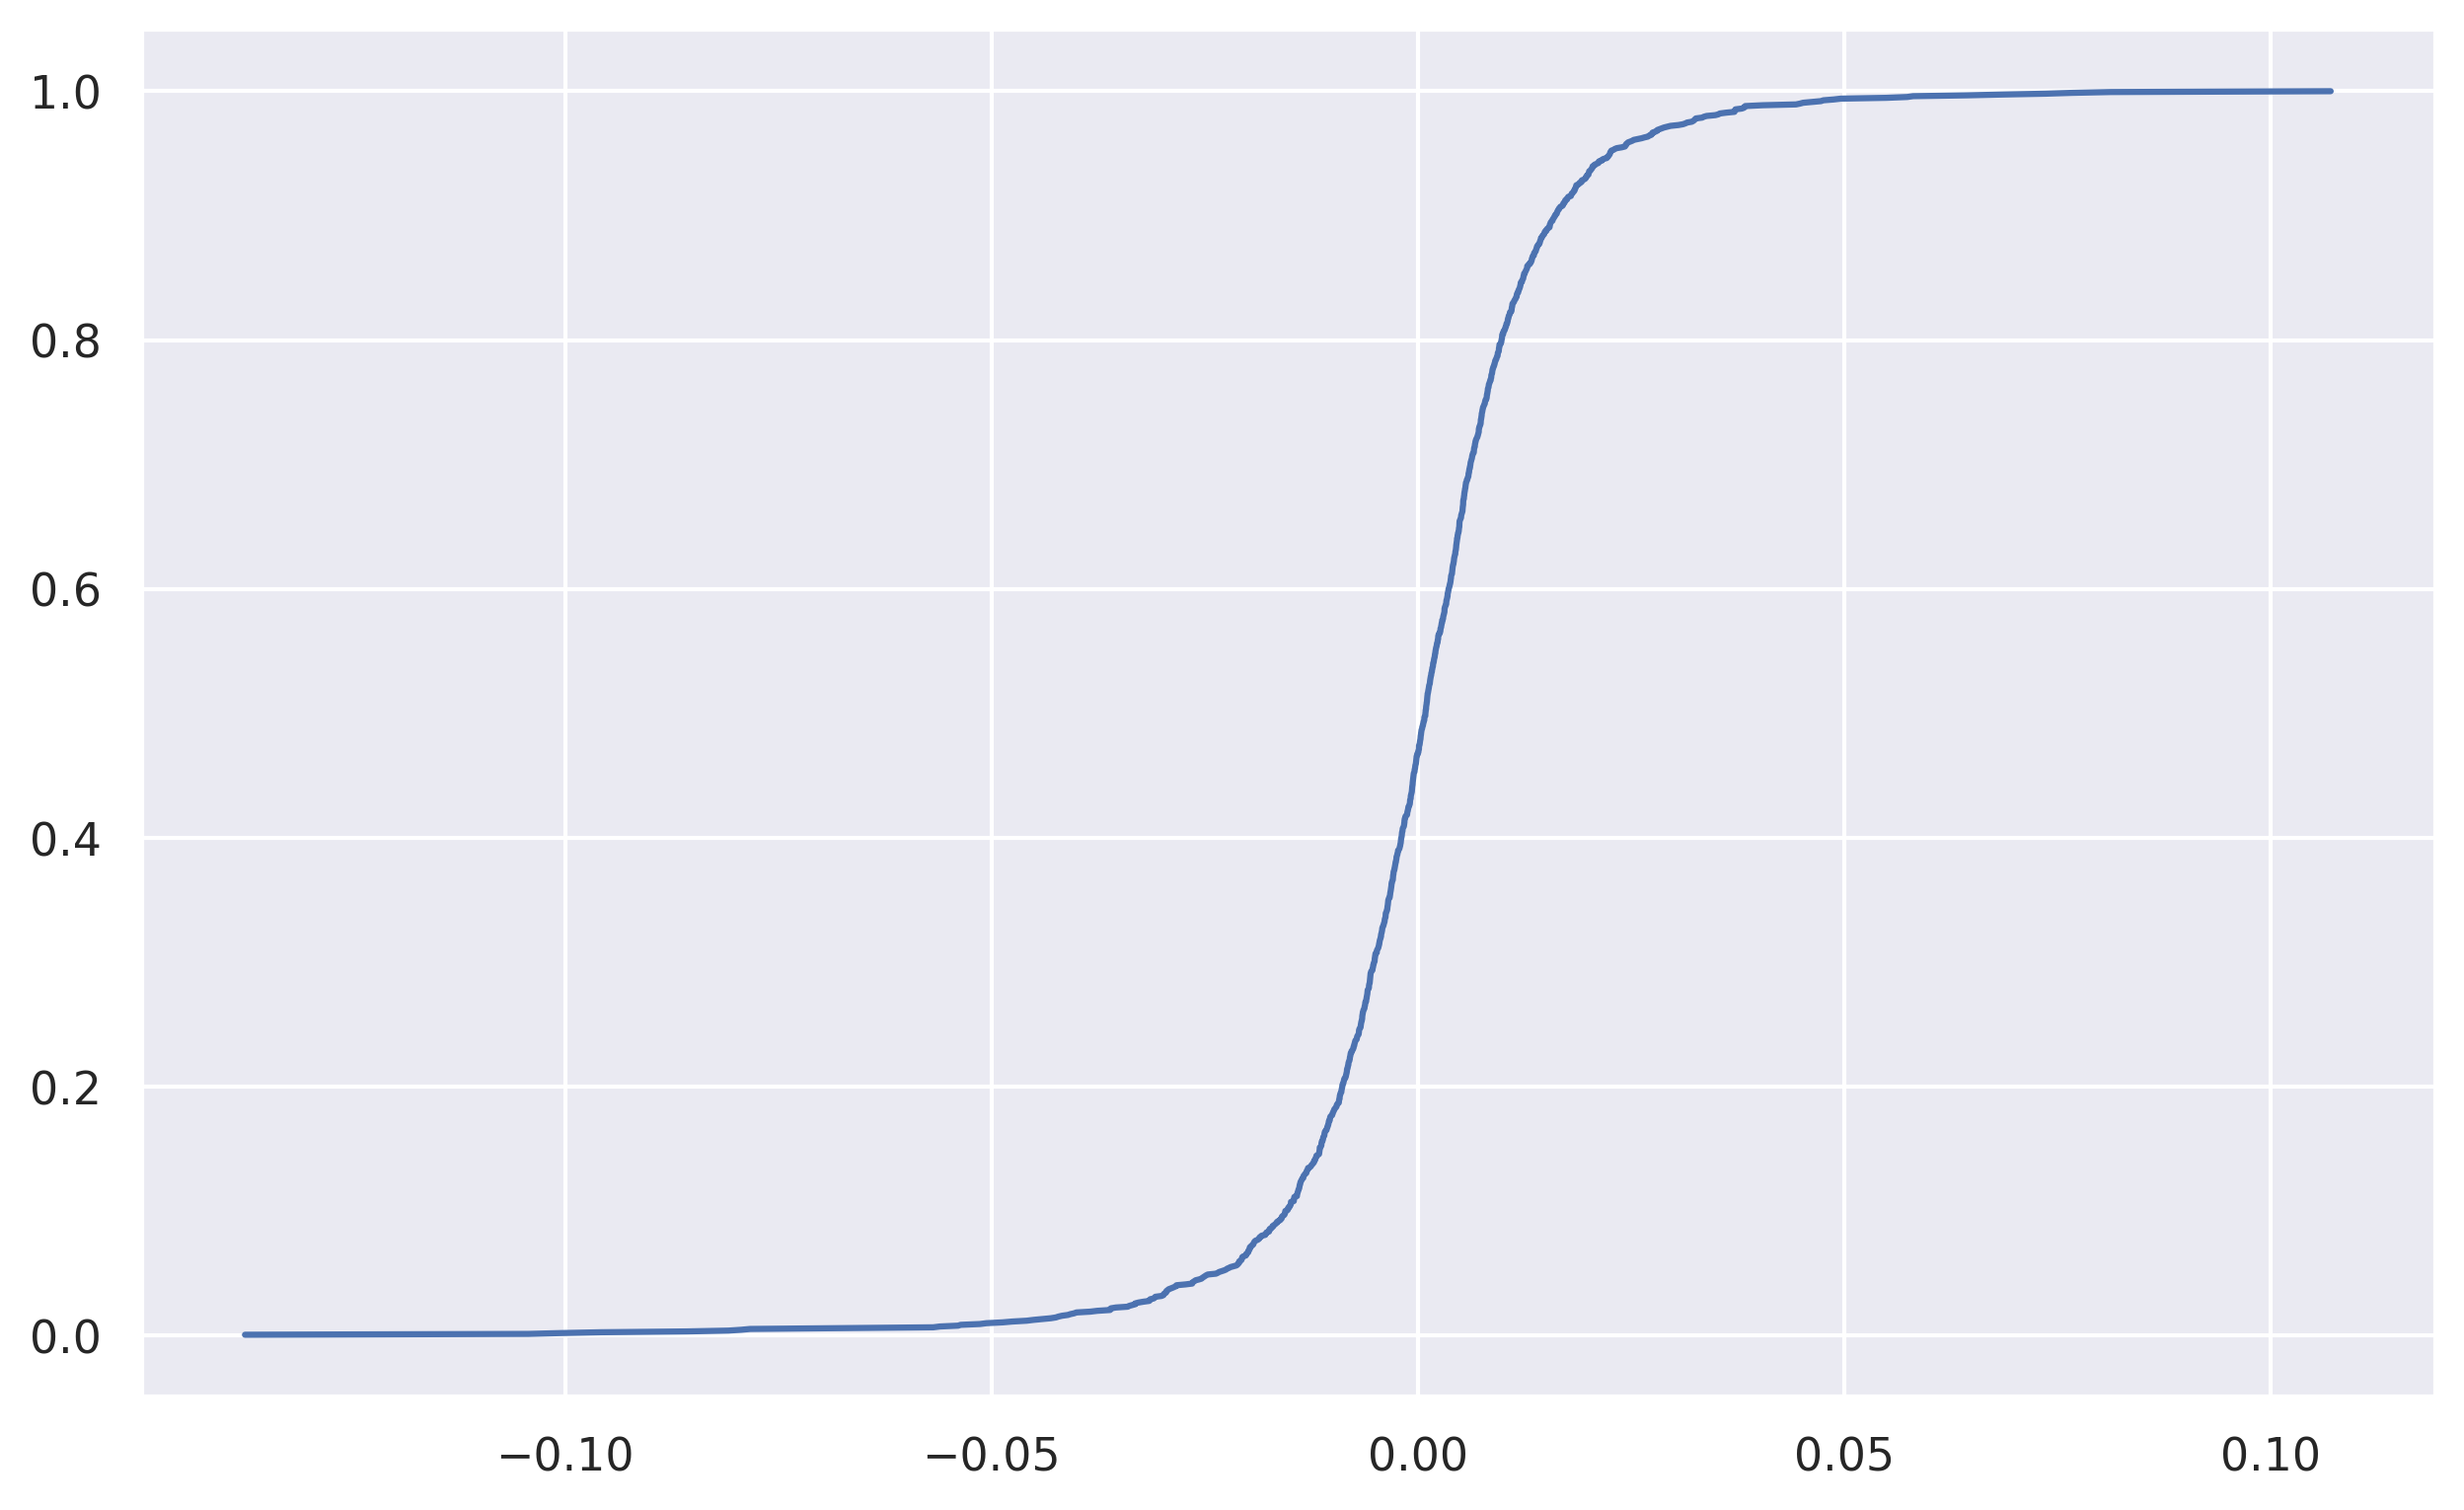

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
# fit della cdf empirica sui dati
ecdf = ECDF(stocks_returns['IBM'])

# plot della cdf empirica per tutti i valori di "x" (i rendimenti IBM, in questo caso)
plt.plot(ecdf.x, ecdf.y)
plt.show()

Esistono due classi per fittare la ecdf: [quella di *scipy*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ecdf.html) e [quella di *statsmodels*](https://www.statsmodels.org/stable/generated/statsmodels.distributions.empirical_distribution.ECDF.html). L'uso della seconda è ben descritto in [questo post](https://machinelearningmastery.com/empirical-distribution-function-in-python/).

Come fatto nel caso del VaR analitico, per prima cosa definiamo la **funzione di calcolo del VaR storico** (ad un dato intervallo di confidenza e per un certo investimento).<br>
La formula è **analoga** a quella del VaR analitico, con il quantile teorico `alpha` **sostituito** dal quantile della distribuzione **empirica**. Non servono, quindi, il vettore delle medie campionarie e la matrice di var-cov inferite dai dati. Con il  VaR storico, infatti, la dipendenza tra i rendimenti degli asset, anche se la congiunta non è gaussiana, "è catturata naturalmente dai dati storici" (*Brandimarte1*, p. 716)

In [ ]:
def VaR_historical(initial_investment, conf_level):

    Hist_percentile = []                              # inizializzazione del vettore dei quantili dei titoli

    for i, j in zip(stocks_returns.columns,           # loop parallelo
                    range(len(stocks_returns.columns))):

        Hist_percentile.append(np.percentile(stocks_returns.loc[:, i], q = (1-conf_level)*100))
                                                      #  il calcolo del quantile EMPIRICO;
                                                      #  l'argomento 'q' deve essere tra 0 e 100 (e non tra 0 e 1) e rappresenta
                                                      #  alpha (e non (1-alpha)!);
                                                      #  il metodo .loc è uno dei metodi di subsetting di pandas:
                                                      #  [:,i] estrae la colonna i-esima di tutte le righe di 'stocks_returns'

        print("In base ai valori storici, il quantile al {:.0f}% dei rendimenti di {} è {:.4f}"
              .format(conf_level*100,i, Hist_percentile[j]))

        VaR_historical = (initial_investment - initial_investment *  # la stessa formula del VaR analitico, ma con il
                          (1 + Hist_percentile[j]))                  # quantile empirico dei rendimenti storici

        print("Il VaR storico per {} è {:.2f} "
              .format(i, VaR_historical))

        print('--' * 38)   # stampa una linea tratteggiata di 35 caratteri di separazione

La struttura del codice di questa funzione `VaR_historical` ricalca quella della funzione  `VaR_analytic`. Non c'è tuttavia `return` finale, cioè la funzione si limita a stampare, non restituisce oggetti.

Stima del VaR in modo storico simulato.

In [ ]:
VaR_historical(initial_investment,conf_level)

In base ai valori storici, il quantile al 95% dei rendimenti di IBM è -0.0234
Il VaR storico per IBM è 23405.22 
----------------------------------------------------------------------------
In base ai valori storici, il quantile al 95% dei rendimenti di MSFT è -0.0296
Il VaR storico per MSFT è 29550.63 
----------------------------------------------------------------------------
In base ai valori storici, il quantile al 95% dei rendimenti di INTC è -0.0345
Il VaR storico per INTC è 34511.36 
----------------------------------------------------------------------------


In [ ]:
conf_level_99 = 0.99
VaR_historical(initial_investment,conf_level_99)

In base ai valori storici, il quantile al 99% dei rendimenti di IBM è -0.0486
Il VaR storico per IBM è 48600.79 
----------------------------------------------------------------------------
In base ai valori storici, il quantile al 99% dei rendimenti di MSFT è -0.0470
Il VaR storico per MSFT è 47009.02 
----------------------------------------------------------------------------
In base ai valori storici, il quantile al 99% dei rendimenti di INTC è -0.0661
Il VaR storico per INTC è 66103.63 
----------------------------------------------------------------------------


## Il VaR di Montecarlo
[[torna ad indice]](#Indice)

Per prima cosa creiamo i **rendimenti simulati** $R_t$ (nel dataframe `sim_data`) **campionandoli** da una distribuzione gaussiana standard, cioè con $E[R_t] = 0$ e $var(R_t) = {\sigma^2} = 1$. (NB. L'assunzione del VaR analitico è semplicemente: $var(R_t) = {\sigma^2}$. Si sceglie qui $\sigma^2 = 1$ per semplicità.)<br>
Il metodo Monte Carlo di calcolo del VaR è in genere accoppiato al [bootstrap](https://it.wikipedia.org/wiki/Bootstrap_(statistica)) per la generazione dei parametri della distribuzione di probabilità dalla quale si campiona.<br>
La cella seguente esegue <u>due passi per ognuno dei titoli del portafoglio</u>:
* stima la media e la dev-std della distribuzione (dalla quale campiona al passo successivo) su un campione gaussiano standard di 100 elementi casuali (il **bootstrap**).
* campiona per 1000 volte (i cosiddetti *trial* della simulazione MC) una variabile gaussiana - che rappresenta il **rendimento simulato del titolo in un certo giorno $R_t$** - con i parametri stimati al passo precedente.<br>

1000 è considerato un numero di trial sufficiente.<br>

In [ ]:
sim_data = pd.DataFrame([])                                               # inizializzazione del dataframe dei rendimenti

num_reps = 1000                                                           # il numero di prove (trial) di Monte Carlo

n = 100                                                                   # la dimensione del vettore di bootstrap

np.random.seed(1)                                                         # impostazione del seme

for i in range(len(stocks.columns)):                                      # loop sui titoli

    # il bootstrap:
    mean = np.random.randn(n).mean()                                      # la media del vettore di bootstrap (circa 0)
    std = np.random.randn(n).std()                                        # la dev-std del vettore di bootstrap (circa 1)

    # la generazione dei 1000 rendimenti (per 3):
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))            # 1000 campionamenti da una gaussiana univariata
                                                                          # con la media e la dev-std bootstrappate prima

    sim_data = pd.concat([sim_data, temp], axis=1)                        # aggiunge la nuova colonna a 'sim_data',
                                                                          # axis=1 concatena per colonna, axis=0 per riga

sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']       # rinomima le colonne (le tre serie storiche simulate)
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,-0.313034,0.372617,0.303900
1,0.828552,1.411422,-0.664911
2,-0.463483,-0.119439,1.270327
3,1.882519,0.434972,1.154414
4,-1.180789,1.114614,0.122561
...,...,...,...
995,-0.085594,3.937627,-1.089084
996,-0.541943,1.528215,0.548240
997,-1.289870,-1.460233,0.273692
998,0.787065,-0.277904,-1.037814


Ora si definisce una funzione, identica a quella del VaR storico, con `sim_data` anzichè `stocks_returns`.<br>
Come per il VaR storico si usa anche qui il **quantile empirico**, ma della distribuzione empirica **simulata** (cioè la distribuzione di `sim_data`) e non di quella storica (cioè di `stocks_returns`,come per il VaR storico)!

In [ ]:
def VaR_MC(initial_investment, conf_level):

    MC_percentile = []                                           # inizializzazione del vettore dei quantili dei titoli

    for i, j in zip(sim_data.columns,                            # loop parallelo
                    range(len(sim_data.columns))):

        MC_percentile.append(np.percentile(sim_data.loc[:, i],q = (1-conf_level)*100))
                                                                 # il calcolo del quantile EMPIRICO sui dati simulati;
                                                                 # l'argomento 'q' deve essere tra 0 e 100 (e non tra 0 e 1) e
                                                                 # rappresenta alpha (e non (1-alpha)!);
                                                                 #  il metodo .loc è uno dei metodi di subsetting di pandas:
                                                                 #  [:,i] estrae la colonna i-esima di tutte le righe
                                                                 # di 'sim_data'

        print("In base alla simulazione di MC, il quantile al {:.0f}%  dei rendimenti di {} è {:.4f}"
              .format(conf_level*100,i, MC_percentile[j]))

        VaR_MC = (initial_investment - initial_investment *      # la solita formula del VaR analitico, qui con il quantile
                    (1 + MC_percentile[j]))                      # empirico dei dati simulati

        print("Il VaR simulato per {} è {:.2f} "
              .format(i, VaR_MC))

        print('--' * 46) # stampa una linea tratteggiata di 35 caratteri di separazione

In [ ]:
VaR_MC(initial_investment, conf_level)

In base alla simulazione di MC, il quantile al 95%  dei rendimenti di Simulation 1 è -1.5237
Il VaR simulato per Simulation 1 è 1523738.72 
--------------------------------------------------------------------------------------------
In base alla simulazione di MC, il quantile al 95%  dei rendimenti di Simulation 2 è -1.4608
Il VaR simulato per Simulation 2 è 1460819.33 
--------------------------------------------------------------------------------------------
In base alla simulazione di MC, il quantile al 95%  dei rendimenti di Simulation 3 è -1.5346
Il VaR simulato per Simulation 3 è 1534610.95 
--------------------------------------------------------------------------------------------


Abbiamo ottenuto VaR molto grandi perchè i quantili sono molto alti (in magnitudine), e ciò perchè abbiamo campionato con **dev_std = 1**.<br>
A titolo di confronto, le tre varianze dei dati storici (il 2020), prese **dalla diagonale principale della matrice `cov_var`** calcolata prima, sono: **[0.000672, 0.000770, 0.001159]**, cioè sono molto più piccole.

# Stressed VaR
[[torna ad indice]](#Indice)

Vedi [questo articolo](https://medium.com/atoti/market-risk-analytics-in-python-interactive-rolling-var-b5688e0d9a92).

# Expected Shortfall
[[torna ad indice]](#Indice)

**Premessa di metodo**<br>
Per capire al meglio la ES, procederemo **a passi successivi**.<br>

Per calcolare la ES occorre calcolare un **valore atteso** $E[X]$ (aka, $\mu_X$ per semplicità) di una variabile casuale *X* (la loss del portafoglio condizionata - vedi dopo). Vediamo prima, in generale (<u>a prescindere da VaR/ES</u>), come si calcola un valore atteso $E[X]$ con *scipy*, prima con *X* discreta e poi *X* continua.<br>

**Caso discreto**<br>
Sia *X* definita su [1,3,5,7,9] in modo uniforme, si ha:
$E[X] = \sum_{i = 1}^{n} x_ip_X(x_i)) = \sum_{i = 1}^{5} x_ip_X(x_i)) = 1*1/5 + 3*1/5 + 5*1/5 + 7*1/5 + 9*1/5 = 25/5 = 5$.<br>
Questa è una <u>media pesata</u>, più precisamente è una combinazione lineare convessa, perchè la somma dei pesi, che sono qui le singole probabilità $p_X(x_i$), è uguale ad 1.<br>

**Caso continuo**<br>
Sia $X \sim {\sf Uniform}(0,1)$, si ha: $$E[X] = \int_{0}^{1}xf_X(x)dx$$<br>
dove $f_X(x)$ è la [PDF](https://en.wikipedia.org/wiki/Probability_density_function) di X. Anche questa è una media pesata, fatta nel continuo tramite questo integrale che somma nell'intervallo [0,1] tutti i possibili (infiniti!) valori di $x$ per la loro rispettiva probabilità $f_X(x)$, in modo infinitesimale ovviamente.<br>
Si utilizza la classe `scipy.stats.uniform` ed il suo metodo `expect`(vedi [qui](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html)), che ha questa firma: `expect(func, args=(), loc=0, scale=1, lb=None, ub=None, conditional=False, **kwds)`.


In [ ]:
from scipy.stats import uniform
uniform.expect(func = lambda x: x, lb = 0, ub = 1)  # oppure loc=0, scale=1
                                                    # --> 0.5

np.float64(0.5)

Qui la funzione `lambda` ha **mappato** *x* in *x*, è la funzione **identità $f(x)=x$**. NB. La *Y* è lambda (e non si può quindi usare nella formula).<br>
Le funzioni lambda in python sono definite e richiamate nella <u>stessa</u> linea di codice, a differenza della predefinizione classica di una funzione python con `def` e `return` (e richiamo successivo).<br>
Vedi [qui](https://en.wikipedia.org/wiki/Lambda_calculus) per il lambda calcolo dal punto di vista matematico e [qui (il primo esempio)](https://realpython.com/python-lambda/) per la sua applicazione in python.

Calcoliamo ora il valore atteso di una $\sf {X \sim Normal (10,5)}$, utilizzando il metodo `expect` della classe `scipy.stats.norm` (vedi [qui](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)):

In [ ]:
from scipy.stats import norm
norm.expect(func = lambda x: x, loc = 10, scale = 5)  # il minimo errore (0.0000.... 2) è dovuto alla
                                                      # approssimazione numerica.

np.float64(10.000000000000002)

Dall'help del metodo `norm.expect`:<br>
*Calculate expected value of a function with respect to the distribution, by **numerical integration**.*<br>
Cioè questo metodo calcola il valore atteso di una variabile (od anche funzione, più in generale) gaussiana, con i due parametri $\mu_X$ (`loc`) e $\sigma_X$ (`scale`) dati.

Ed or il valore atteso di una $\sf {f(x) = 3 + 2X}$, con $\sf {X \sim Normal ( 10 , 5 )}$ e quindi anche $\sf {f(x)}$ gaussiana per la nota [proprietà riproduttiva della gaussiana](https://www.roma1.infn.it/~dagos/PRO/node182.html) con le combinazioni lineari:

In [ ]:
norm.expect(func = lambda x: 3+2*x, loc = 10, scale = 5)

np.float64(23.000000000000004)

Infatti: $E[3 + 2X] = 3 + 2E[X] = 3 + 2*10 = 23$

**Concludendo**: per quanto ora visto, se il **rendimento** $R_T$ di un asset finanziario - cioè una singola variabile casuale *X* - è <u>continuo</u> (come è frequente), il suo $E[R_T]$ (o $\mu_{R_T}$ per semplicità) <u>nell'intervallo $[a,b]$</u> è dato dalla seguente formula:
$$E[R_T] = \int_{a}^{b}r_Tf_{R_T}(r_T)dr_T$$

dove $f_{R_T}$ è la distribuzione univariata di $R_T$.<br>
Assumendo la gaussianità di $R_T$, la precedente formula è implementata in python dalla seguente `expect`, dove:
* `x` è qui $R_T$ di un asset
* la gaussianità della $f_{R_T}$ è implicita nella classe `scipy.stats.norm`;
* `loc` e `scale` sono i due parametri stimati della gaussiana $\hat{\mu_{R_T}}$ e $\hat{\sigma_{R_T}}$ (ad esempio, stimati dai dati storici);
* `lb` è il lower bound dell'integrale, qui *a*
* `ub` è l'upper bound dell'integrale, qui *b*

Come esempio finale, prima di tornare al VaR ed alla ES, calcoliamo il valore atteso del **rendimento di IBM** in un dato intervallo [a,b]. Assumiamo che questo rendimento sia gaussiano (la STESSA assunzione che facciamo nel caso del VaR / ES analitici). La gaussianità nella cella sottostante è garantita dalla classe `norm`. La distribuziine gaussiana ha 2 parametri, come noto ($\mu$ e $\sigma$) che il metodo  `expect` chiama `loc` e `scale` e che noi stimiamo inferendoli dalla popolazione.

In [ ]:
a = 0.02
b = 0.03
norm.expect(
         # 'x' è il rendimento del titolo IBM (appunto continuo e gaussiano)

         func = lambda x: x,                     # la funzione identità espressa come lambda function
                                                 # (quindi definita nella stessa linea di codice)

         # dall'help del metodo 'norm.expect':
         #    lb, ub : scalar, optional
         #    Lower and upper bound for integration. Default is set to the
         #       support of the distribution (una variabile gaussiana ha supporto infinito)

         lb = a,                                 # l'estremo inferiore di integrazione (nel caso della ES sarà 1-alpha)
         ub = b,                                 # l'estremo superiore di integrazione (nel caso della ES sarà 1)

         loc = stocks_returns.mean()[0],         # il valore atteso (storico su 6 anni) del rendimento di IBM
         scale = stocks_returns.std()[0])        # la dev.std (storica su 6 anni) del rendimento di IBM

np.float64(0.0019326142400714408)

In [ ]:
stocks_returns.mean()[0]

np.float64(0.00026051979965473486)

> L'approccio object-oriented di Python fornisce alcuni vantaggi, ad esempio l'ereditarietà delle classi, ma, quando applicato alla Data Science ed al Machine Learning, è spesso poco intuitivo. Per l'utente medio di Python è più intuitivo pensare il calcolo di un quantile di una distribuzione o di un valore atteso come **funzioni** anzichè metodi di una classe!

## ES analitico
[[torna ad indice]](#Indice)

Per calcolare la ES analitica partiamo dalla **formula della teoria**:
$$ES_{1-\alpha} = \frac{1}{\alpha}\int_{1-\alpha}^{1}VaR_udu$$

dove la variabile di integrazione *u* viene fatta variare da $(1-\alpha)$ ad 1, cioè progressivamente rimpicciolendo $\alpha$.

**Come esprimere il VaR?**

Come sappiamo dalle formule del VaR del prof. Karasan viste prima, la formula del $VaR_{1-\alpha}$ analitico può essere così semplificata algebricamente:


$\sf {VaR_{1-\alpha} = W_0 - (W_0 + r_{\alpha})}$ (*la formula di Karasan*) = ... proseguendo lo sviluppo algebrico: $\sf {W_0 - W_0 - W_0r_{\alpha} = -W_0r_{\alpha} = W_0(-r_{\alpha})}$.<br>

dove $W_0$ è lo *initial_investment* ed $r_{\alpha}$ è il quantile $\alpha$ della distribuzione gaussiana del rendimento (eventualmente congiunta nel caso di portafoglio), come noto. <br>

> Una **nota matematica importante**, utile per meglio comprendere (concettualmente) le formule del VaR (già viste) e quelle della ES (che stiamo per vedere): come noto $L_T = -W_0R_T$, dove $L_T$ è la notazione di loss più precisa, perchè la loss sempre è riferita ad un <u>periodo $T$ di detenzione del titolo/portafoglio</u>. Questa struttura rimane invariata anche se trasportata ai quantili. Infatti si ha: $VaR_{1-\alpha} = -W_0r_\alpha$, come visto adesso, dove $VaR_{1-\alpha}$ è il quantile $(1-\alpha)$ di $L_T$ e $r_\alpha$ è il quantile $\alpha$ di $R_T$!  

Nel caso delle distribuzioni di probabilità **simmetriche** (come la gaussiana, la t di Student, ecc), per ogni quantile si ha che: $q_{1-\alpha} = -q_\alpha$, come vediamo qui sotto per la gaussiana standard:

In [ ]:
print(scipy.stats.norm.ppf(q=0.95))  # quantile 1-alpha
print(scipy.stats.norm.ppf(q=0.05))  # quantile alpha

1.6448536269514722
-1.6448536269514729


Dunque si ha, *a.* riprendendo la formula precedente della ES, *b.* **sostituendo** in essa $VaR_{1-\alpha}$ con $W_0(-r_\alpha)$ e *c.* applicando la proprietà dei quantili simmetrici:

$$ES_{1-\alpha} = \frac{1}{\alpha}\int_{1-\alpha}^{1}VaR_udu = \frac{1}{\alpha}\int_{1-\alpha}^{1}W_0(r_u)du$$

Il codice della cella seguente **implementa questa equazione (nel suo ultimo membro)**, <u>ricordando che</u>:

* $\frac{1}{\alpha}\int_{1-\alpha}^{1}W_0(r_{1-\alpha})du = E[L|L \ge VaR_{1-\alpha}]$, come ricordato prima a proposito dei valori attesi;<br><br>
* abbiamo sopra impostato la variabile `conf_level` come appunto $1-\alpha$, come dice il nome stesso della variabile (controlla il valore in Jupyter con lo strumento *Variable Inspector*), e che dunque :`1-conf_level` = $\alpha$ (il livello di tolleranza):

In [ ]:
def ES_analytic(initial_investment , conf_level):

    alpha = - norm.ppf(q = 1 - conf_level, loc = stocks_returns_mean, scale = std_port)
                   # i 3 quantili r_alpha in negativo, utilizzati tra qualche riga per calcolare il VaR_1-alpha nel nuovo modo

    for i, j in zip(stocks.columns, range(len(stocks.columns))):   # il consueto loop parallelo

        # 1. il calcolo del VaR analitico (per confronto):

        VaR_analytic = (initial_investment * alpha)[j]  # il VaR_1-alpha calcolato con la nuova formula W0(-r_alpha)

        # 2. il calcolo dell'ES analitico (vedi la formula precedente):

        ES_analytic = (1 / (1 - conf_level)) * initial_investment * norm.expect(

                                 # qui f(x) = x, cioè la funzione identità;
                                 # 'x' è il rendimento del portafoglio (appunto gaussiano)

                                 func = lambda x: x,                     # lambda function (cioè definita nella linea di codice)

                                 # dall'help del metodo 'norm.expect':
                                 #    lb, ub : scalar, optional
                                 #    Lower and upper bound for integration. Default is set to the
                                 #       support of the distribution (una variabile gaussiana ha supporto infinito)

                                 lb = norm.ppf(conf_level,               # il lower bound dell'integrale (upper bound = + inf)
                                               stocks_returns_mean[j],
                                               std_port),

                                 loc = stocks_returns_mean[j],           # il valore atteso (storico su almeno 1 anno) del rendimento
                                 scale = std_port)                       # la dev.std (storica su almeno 1 anno) del rendimento

        print("VaR analitico per {} è {:.0f} ".format(i,VaR_analytic))
        print("ES analitico per {} è {:.0f} ".format(i,ES_analytic))


La cella precedente ha fatto uso:
* del metodo `expect` della classe `scipy.stats.norm`, **adattandolo al portafoglio**, e quindi gli argomenti `lb`, `loc` e `scale` sono <u>valorizzati dalla distribuzione congiunta dei rendimenti del portafoglio</u> e non del singolo titolo, come invece nell'esempio precedente con il titolo IBM;<br>
NB `stocks_returns_mean[j]` $\equiv$ `stocks_returns.mean()[j]`
* della funzione identità `lambda x: x` del lambda calcolo.

In [ ]:
ES_analytic(initial_investment, conf_level)

VaR analitico per IBM è 42753 
ES analitico per IBM è 53416 
VaR analitico per MSFT è 41331 
ES analitico per MSFT è 54837 
VaR analitico per INTC è 43361 
ES analitico per INTC è 52808 


Ciò significa, ad esempio per IBM, che c'è una probabilità $\alpha$ che la loss superi il VaR di 42753; in questo caso la perdita attesa (media) è 53416.

## ES storico
[[torna ad indice]](#Indice)

Come per il VaR, l'ES storico è definito semplicemente sostituendo il quantile teorico con quello **empirico**.<br>
Definiamo la funzione di calcolo dell'ES storico:

In [ ]:
def ES_historical(initial_investment, conf_level):

    for i, j in zip(stocks_returns.columns, range(len(stocks_returns.columns))):    # il consueto loop

        # calcolo del quantile al livello di confidenza alpha dei rendimenti:
        ES_hist_percentile = np.percentile(stocks_returns.loc[:, i], q = (1-conf_level)*100)

        # stima della ES
        ES_historical = stocks_returns[str(i)][stocks_returns[str(i)] <= ES_hist_percentile].mean()

        print("ES storico per {} è {:.0f} ".format(i, initial_investment * ES_historical))

In [ ]:
ES_historical(initial_investment, conf_level)

ES storico per IBM è -41374 
ES storico per MSFT è -43087 
ES storico per INTC è -56976 


I segni sono negativi. Perchè?<br>
**Mio messaggio all'autore** del 21.1.24:<br>
*In chapter 5, your python code computes historical ES much less than related VaR (even negative!). How is it possible? I suspect a bug in the code, but I can't find it.*<br>
**Risposta dell'autore** del 10.2.2024:<br>
*As I used the stock returns (and not the loss distribution), I focus on the left hand-side of the distribution, which is negative. As expected, shortfall considers extreme cases (ES> VaR), this is more pronounced. Some researchers use the loss distribution and concentrate on the right-hand side of the distribution and so it is given as positive. So, please do not confuse with sign, there are the same things. You can also calculate the absolute values of the result.*

# Funzioni VaR della Bocconi
[[torna ad indice]](#Indice)

Da [qui](https://bsic.it/wp-content/uploads/2017/03/VaR-with-Python.pdf).<br>
Segue il codice (non commentato!), da adattare al vostro dataframe.

In [ ]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import math

In [ ]:
def VaR(Returns, Formula = 'Parametric Normal', Confidence_Interval = 0.95 , Period_Interval = None ,
        EWMA_Discount_Factor = 0.94, Series = False ,removeNa = True):

    '''
    This funcction can caluclate both single value VaR and series of VaR values through time.
    Supported formulas as Parametric Normal, Parametric EWMA, Historical Simulation and Filtered Historical Simulation

    '''


    # Removes the NAs from the series
    if removeNa==True: Returns = Returns[pd.notnull(Returns)]

    # Data need to be returns already, then here the interval for the sampling is set for No input
    if (Series == True and Period_Interval == None):
        Period_Interval = 100
    elif Period_Interval == None:
        Period_Interval = len(Returns)

    #==========================================================================
    #==========================================================================
    #==========================================================================

    #===============================
    #     Parametric Normal VaR
    #===============================
    if Formula == 'Parametric Normal':

        if Series == False:
            Data = Returns[-Period_Interval:]
            stdev = np.std(Data)
            Value_at_Risk = stdev*norm.ppf(Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'ParVaR')
            for i in range(0,len(Returns)-Period_Interval):
                if i == 0: Data = Returns[-(Period_Interval):]
                else: Data = Returns[-(Period_Interval+i):-i]
                stdev = np.std(Data)
                Value_at_Risk[-i-1] = stdev*norm.ppf(Confidence_Interval)

    #============================
    # EWMA Parametric VaR
    #============================
    if Formula == 'Parametric EWMA':

        ## Defining exponentially smoothed weights components ##
        Degree_of_Freedom = np.empty([Period_Interval,])
        Weights = np.empty([Period_Interval,])
        Degree_of_Freedom[0]=1.0
        Degree_of_Freedom[1]=EWMA_Discount_Factor
        Range = range(Period_Interval)
        for i in range(2,Period_Interval):
            Degree_of_Freedom[i]=Degree_of_Freedom[1]**Range[i]
        for i in range(Period_Interval):
            Weights[i]=Degree_of_Freedom[i]/sum(Degree_of_Freedom)

        if Series == False:
            sqrdData = (Returns[-Period_Interval:])**2 ## Squaring returns for the formula
            EWMAstdev=math.sqrt(sum(Weights*sqrdData))
            Value_at_Risk = EWMAstdev*norm.ppf(Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'EWMAVaR')
            sqrdReturns = Returns**2 ## For efficiency here we square returns first so the loop does not do it repeadetly
            ## This loop repeats the VaR calculation iterated for every xxx period interval
            for i in range(0,len(Returns)-Period_Interval):
                ## this is needed as, supposing x is a number, referencing a pd series as a[x,0] is a mistake. correct is a[x:]
                if i == 0: sqrdData = sqrdReturns[-(Period_Interval):]
                else: sqrdData = sqrdReturns[-(Period_Interval+i):-i]

                EWMAstdev=math.sqrt(sum(Weights*sqrdData))
                ## unfortunately pd series work differently for singular entries. So if a[x:] gets up to the last number
                ## a[] does not work. So a[-1] will get the equivalent to the last of a[x:-1]
                Value_at_Risk[-i-1] = EWMAstdev*norm.ppf(Confidence_Interval)


    #============================
    #    Historical Simulation
    #============================
    if Formula == 'Historical Simulation':

        if Series == False:
            Data = Returns[-Period_Interval:]
            Value_at_Risk = -np.percentile(Data,1-Confidence_Interval)
        if Series == True:
            Value_at_Risk = pd.Series(index=Returns.index, name = 'HSVaR')
            for i in range(0,len(Returns)-Period_Interval):
                if i == 0: Data = Returns[-(Period_Interval):]
                else: Data = Returns[-(Period_Interval+i):-i]
                Value_at_Risk[-i-1] = -np.percentile(Data,1-Confidence_Interval)

    #====================================
    #   Filtered Historical Simulation
    #====================================
    if Formula == 'Filtered Historical Simulation':

        # Defining exponentially smoothed weights components
        Degree_of_Freedom = np.empty([Period_Interval,])
        Weights = np.empty([Period_Interval,])
        Degree_of_Freedom[0]=1.0
        Degree_of_Freedom[1]=EWMA_Discount_Factor
        Range = range(Period_Interval)
        for i in range(2,Period_Interval):
            Degree_of_Freedom[i]=Degree_of_Freedom[1]**Range[i]
        for i in range(Period_Interval):
            Weights[i]=Degree_of_Freedom[i]/sum(Degree_of_Freedom)


        Value_at_Risk = pd.Series(index=Returns.index, name = 'FHSVaR')
        EWMAstdev = np.empty([len(Returns)-Period_Interval,])
        stndrData = pd.Series(index=Returns.index)

        # For efficiency here we square returns first so the loop does not do it repeadetly
        sqrdReturns = Returns**2

        # Computations here happen in different times, because we first need all the EWMAstdev
        # First get the stdev according to the EWMA
        for i in range(0,len(Returns)-Period_Interval):
            if i == 0: sqrdData = sqrdReturns[-(Period_Interval):]
            else: sqrdData = sqrdReturns[-(Period_Interval+i):-i]

            EWMAstdev[-i-1]=math.sqrt(sum(Weights*sqrdData))

        # Now get the Standardized data by dividing for the EWMAstdev.
        # Length is here -1 because we standardize by the EWMAstdev of the PREVIOUS period.
        # Hence also EWMAstdev is [-i-2] instead of [-i-1].
        for i in range(0,len(Returns)-Period_Interval-1):
            stndrData[-i-1]=Returns[-i-1]/EWMAstdev[-i-2]
        stndrData = stndrData[pd.notnull(stndrData)]
        #Finally get the percentile and unfilter back the data
        for i in range(0,len(stndrData)-Period_Interval):
            if i == 0: stndrData2 = stndrData[-(Period_Interval):]
            else: stndrData2 = stndrData[-(Period_Interval+i):-i]

            stndrData_pct=np.percentile(stndrData2,1-Confidence_Interval)
        # Unfilter back with the CURRENT stdev
            Value_at_Risk[-i-1]=-(stndrData_pct*EWMAstdev[-i-1])


        # For FHS the single take of VaR does not work because we need to standardize for the preceeding stdev
        # hence it is always necessary to calculate the whole series and take the last value
        if Series == True:
            Value_at_Risk = Value_at_Risk
        if Series == False:
            Value_at_Risk = Value_at_Risk[-1]



    return(Value_at_Risk)

In [ ]:
def VaR_Compare(Returns, Confidence_Interval = 0.95 , Period_Interval = 100 ,EWMA_Discount_Factor = 0.94):

    'This function calculates different VaR series and plots it in the same graph'

    # Use for each VaR call the same values, here they are set
    Ret=Returns
    CI = Confidence_Interval
    PI = Period_Interval
    EWMAdf = EWMA_Discount_Factor

    # Call the single VaR series
    VaRPN=VaR(Ret, Formula = 'Parametric Normal', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaREWMA=VaR(Ret, Formula = 'Parametric EWMA', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaRHS=VaR(Ret, Formula = 'Historical Simulation', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)
    VaRFHS=VaR(Ret, Formula = 'Filtered Historical Simulation', Confidence_Interval = CI , Period_Interval = PI ,
        EWMA_Discount_Factor = EWMAdf, Series = True ,removeNa = True)

    # Concat the different VaR series in the same dataframe and plot it
    AllVaR = pd.concat([VaRPN,VaREWMA,VaRHS,VaRFHS], axis = 1)
    AllVaR.plot(lw=1)

    return(AllVaR)

In [ ]:
VaR_Compare(stocks["Adj Close"])  # la chiamata mia

# Come usare le funzioni di questo notebook con i propri dati
[[torna ad indice]](#Indice)

Il presente notebook include sia aspetti didattici che software a titolo definittivo.<br>
Salvare questo notebook con altro nome (per sicurezza), sempre nella medesima directory, altrimenti non è possibile includere le varie immagini png.<br>
Dopo avere acquisito familiarità sufficiente con questo notebook e **questi dati** (di *Alpha Vantage*), potrete personalizzare il notebook - e soprattutto creare le vostre funzioni (VaR_*, ES_*, elencate ad inizio notebook) in questo modo:
* eseguire sequenzialmente il codice dall'inizio sino alla sezione `Caricamento dei dati`;
* NON eseguire la sezione `Caricamento dei dati`, ma creare in altro modo un dataframe di nome `stocks` con i VOSTRI dati;
* se NON avete ancora i rendimenti storici dei titoli, ma solo le serie storiche dei prezzi, dovete rinominare il vostro dataframe come `stocks`, che dovrà avere la seguente struttura: una prima colonna di *timestamp* (cioè date), seguita da una o più colonne con i prezzi di ciascun titolo contenuto nel vostro portafoglio; le colonne 'prezzo' dovranno essere in formato numerico;
* il numero di righe del dataframe `stocks` potrà assumere qualsiasi valore;
* il notebook è stato costruito per essere indipendente rispetto al nome ed al numero delle colonne 'prezzo' dei vari titoli, che potranno quindi assumere (nel dataframe `stock`) qualsiasi nome (e non quelli del dataframe di questo notebook);
* se invece avete già i rendimenti storici dei titoli del portafoglio, allora NON dovete creare l'oggetto `stocks`, ma direttamente rinominare il vostro dataframe dei rendimenti come `stocks_returns`;
* saltare le celle di esempi e di teoria con immagini;
* definire (creare) le funzioni suddette;
* infine, utilizzare le funzioni suddette, fornendo loro gli argomenti in input (come da documentazione fornita), secondo le vostre necessità.

Una volta acquisita familiarità con l'ambiente Jupyter, Python e le suddette funzioni, potrete liberamente estrarre le celle del notebook che definiscono le suddette funzioni ed importarle nel vostro notebook. Da quel punto in poi sarete autonomi.